# **Using a singular model-structure to predict the data**


## Data Import

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
import keras

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [5]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = sorted(pollution_data.keys())
agents = sorted(set(agent for station in stations for agent in pollution_data[station].keys()))

## Data Merging

- Traffic data is per-station, but it should be normalized globally. To do so we first merge the data, we apply normalization, and later use the date and the statino to merge the data with the pollutants.

In [6]:
merged_traffic_data = pd.concat(
    [df.assign(Station=key) for key, df in traffic_data.items()]
)
print(merged_traffic_data.resample('1h').max().isna().sum())
merged_traffic_data

Traffic_value    0
Station          0
dtype: int64


,Traffic_value,Station
Date,,
2019-01-01 00:00:00,27629.0,GIARDINI MARGHERITA
2019-01-01 01:00:00,44430.0,GIARDINI MARGHERITA
2019-01-01 02:00:00,40318.0,GIARDINI MARGHERITA
2019-01-01 03:00:00,25661.0,GIARDINI MARGHERITA
2019-01-01 04:00:00,15906.0,GIARDINI MARGHERITA
...,...,...
2024-12-31 19:00:00,19786.0,VIA CHIARINI
2024-12-31 20:00:00,16239.0,VIA CHIARINI
2024-12-31 21:00:00,7226.0,VIA CHIARINI


In [7]:
scaler = StandardScaler()
scaled_traffic_data = merged_traffic_data.copy()
scaled_traffic_data['Traffic_value'] = scaler.fit_transform(merged_traffic_data[['Traffic_value']])
scaled_traffic_data

,Traffic_value,Station
Date,,
2019-01-01 00:00:00,-0.366692,GIARDINI MARGHERITA
2019-01-01 01:00:00,0.111507,GIARDINI MARGHERITA
2019-01-01 02:00:00,-0.005531,GIARDINI MARGHERITA
2019-01-01 03:00:00,-0.422706,GIARDINI MARGHERITA
2019-01-01 04:00:00,-0.700359,GIARDINI MARGHERITA
...,...,...
2024-12-31 19:00:00,-0.589924,VIA CHIARINI
2024-12-31 20:00:00,-0.690881,VIA CHIARINI
2024-12-31 21:00:00,-0.947414,VIA CHIARINI


- weather data is global, we only have to normalize it. Since that it is a singular df, we add the date encodings to this dataframe for semplicity. Encodings seemed to be very helpful with singular models.

In [8]:
scaler = StandardScaler()
encoded_weather_data = encode_date_index(weather_data.copy(), method='radial_months-sin-cos_days_hours')
scaled_weather_data = encoded_weather_data.copy()
scaled_weather_data[:] = scaler.fit_transform(scaled_weather_data)
print(scaled_weather_data.resample('1h').max().isna().sum())
scaled_weather_data

TAVG            0
PREC            0
RHAVG           0
RAD             0
W_SCAL_INT      0
W_VEC_DIR       0
LEAFW           0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_rbf_1     0
month_rbf_2     0
month_rbf_3     0
month_rbf_4     0
month_rbf_5     0
month_rbf_6     0
month_rbf_7     0
month_rbf_8     0
month_rbf_9     0
month_rbf_10    0
month_rbf_11    0
month_rbf_12    0
dtype: int64


,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,day_sin,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 03:00:00,-1.816457,-0.136824,1.278379,-0.661589,-1.308868,-0.171911,-0.465156,1.000000e+00,1.000000,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 04:00:00,-1.746206,-0.136824,1.020722,-0.661589,-1.308868,-0.357363,-0.465156,1.224745e+00,0.707107,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-1.113941,-0.136824,0.743245,-0.661589,-0.260449,0.441767,-0.465156,-1.366025e+00,0.366025,-3.387421e-16,...,-0.385296,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386058,-0.386438,0.110871,3.229888
2024-12-31 20:00:00,-0.985147,-0.136824,0.525228,-0.661589,0.236170,0.355222,-0.465156,-1.224745e+00,0.707107,-3.387421e-16,...,-0.385296,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386058,-0.386438,0.110871,3.229888
2024-12-31 21:00:00,-1.055398,-0.136824,0.629282,-0.661589,0.236170,0.345107,-0.465156,-1.000000e+00,1.000000,-3.387421e-16,...,-0.385296,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386058,-0.386438,0.110871,3.229888


- The agent values should be normalized to avoid exploding losses.

In [9]:
for station in stations:
    for agent, d_agent_values in pollution_data[station].items():
        num = d_agent_values.isna().sum()['Agent_value']
        if num > 0:
            print(f'Found {num} nan values in {agent}-{station}')
        pollution_data[station][agent] = d_agent_values.dropna()


Found 12 nan values in PM2.5-GIARDINI MARGHERITA


In [10]:
for station in stations:
    print(station)
    for agent, d_agent_values in pollution_data[station].items():
        print(f'{agent}, mean:{d_agent_values.mean().values}, std:{d_agent_values.std().values}')

GIARDINI MARGHERITA
NO2, mean:[17.136603], std:[12.58761659]
O3, mean:[48.99323253], std:[37.84616729]
PM10, mean:[22.26428571], std:[14.5159852]
PM2.5, mean:[14.07004259], std:[11.64893743]
PORTA SAN FELICE
C6H6, mean:[0.96815171], std:[0.73186373]
CO, mean:[0.57824508], std:[0.30989166]
NO2, mean:[39.71247259], std:[19.29527905]
PM10, mean:[25.35186916], std:[15.49075706]
PM2.5, mean:[15.62155856], std:[11.8599453]
VIA CHIARINI
NO2, mean:[17.89565015], std:[13.3441576]
O3, mean:[44.3085222], std:[38.50506211]
PM10, mean:[22.28632075], std:[13.78403511]


Each agent should be normalized across all station, since  that the model heads will be per agent and not per station-agent.

In [11]:
agent_distributions = {} # dict agent:tuple[mean, std]

for agent in agents:
    aux = pd.concat([pollution_data[station][agent] for station in stations if agent in pollution_data[station]])
    agent_distributions[agent] = (aux.mean().values[0], aux.std().values[0])

agent_distributions

{'C6H6': (0.968151707217338, 0.7318637341961725),
 'CO': (0.5782450785309969, 0.309891655957885),
 'NO2': (24.913462160309393, 18.596382857259),
 'O3': (46.65500610145854, 38.24806274787606),
 'PM10': (23.31053459119497, 14.686639799892715),
 'PM2.5': (14.851268796992482, 11.779853473663676)}

In [12]:
normalized_pollution_data = pollution_data.copy()

for station in stations:
    for agent in normalized_pollution_data[station]:
        normalized_pollution_data[station][agent] = (normalized_pollution_data[station][agent] - agent_distributions[agent][0]) / agent_distributions[agent][1]

for agent in agents:
    aux = pd.concat([normalized_pollution_data[station][agent] for station in stations if agent in normalized_pollution_data[station]])
    print(agent, round(aux.mean().values[0], 2), round(aux.std().values[0], 2))

C6H6 -0.0 1.0
CO 0.0 1.0
NO2 -0.0 1.0
O3 -0.0 1.0
PM10 -0.0 1.0
PM2.5 -0.0 1.0


- We can now divide the traffic per station, merge them with the weather and create the input sequences. For every agent of the same station, the input data is the same.
    
    We might also want to consider adding new informations, like the date encodings and so on...

In [13]:
station_data = {
    station: pd.merge(
        scaled_traffic_data[scaled_traffic_data['Station'] == station].drop(columns=['Station']),
        scaled_weather_data,
        left_index=True,
        right_index=True
    )
    for station in stations
}
for station in station_data:
    display(station, station_data[station].resample('1h').max().isna().sum(), station_data[station].head(3))

'GIARDINI MARGHERITA'

Traffic_value    0
TAVG             0
PREC             0
RHAVG            0
RAD              0
W_SCAL_INT       0
W_VEC_DIR        0
LEAFW            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
month_rbf_1      0
month_rbf_2      0
month_rbf_3      0
month_rbf_4      0
month_rbf_5      0
month_rbf_6      0
month_rbf_7      0
month_rbf_8      0
month_rbf_9      0
month_rbf_10     0
month_rbf_11     0
month_rbf_12     0
dtype: int64

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.366692,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,0.111507,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,-0.005531,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714


'PORTA SAN FELICE'

Traffic_value    0
TAVG             0
PREC             0
RHAVG            0
RAD              0
W_SCAL_INT       0
W_VEC_DIR        0
LEAFW            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
month_rbf_1      0
month_rbf_2      0
month_rbf_3      0
month_rbf_4      0
month_rbf_5      0
month_rbf_6      0
month_rbf_7      0
month_rbf_8      0
month_rbf_9      0
month_rbf_10     0
month_rbf_11     0
month_rbf_12     0
dtype: int64

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.011177,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,0.599669,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,0.316324,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714


'VIA CHIARINI'

Traffic_value    0
TAVG             0
PREC             0
RHAVG            0
RAD              0
W_SCAL_INT       0
W_VEC_DIR        0
LEAFW            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
month_rbf_1      0
month_rbf_2      0
month_rbf_3      0
month_rbf_4      0
month_rbf_5      0
month_rbf_6      0
month_rbf_7      0
month_rbf_8      0
month_rbf_9      0
month_rbf_10     0
month_rbf_11     0
month_rbf_12     0
dtype: int64

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.913856,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,-0.724523,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,-0.787369,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714


Sequences should also be indexed with the date of the last element, so that merging with the agent will be easier. To do so, we simply use one variable for the sequences and one for the dates.

In [14]:
hourly_time_steps = 3
daily_time_steps = 24

In [15]:
station_sliding_windows = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station],
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=hourly_time_steps
    )
    dates = dates.index.tolist()
    station_sliding_windows[station] = sequences, dates

In [16]:
station_sequences = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station].drop(columns=['hour_sin', 'hour_cos']),
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=daily_time_steps,
        sliding_window=False
    ) 
    station_sequences[station] = sequences, dates

- At this point we should create the actual train data composed of sequence + agentID and the target values. We could of course create an huge dataset and directly use it, but I dont know if it is too big and with too many repeated values (sequences are repeated for each agent and each sequence share some rows).

    <!-- For now, I simply try to make a dataset made of `in=(station_date, sequence)`, `x=(station_date, agent)` and `y=(target)`. I don't want the model to learn station and agent.  -->
    The model should be able to take a batch and use the dates to access the sequences, create the embeddings, and use the agent to predict the concentration using the correct classification head. Since that we have to map a dict would be suitable for fast data access.

- Also, at this point we have to divide hourly and daily agents because the embedding we are trying to create for the stations can be quite different. For example if we have to predict an hourly pollutant, we might want to use 3/5 prev. hours. For daily agents instead, the whole 24 hours might be helpful.

In [17]:
def create_key(station, date):
    return (station+' '+date).replace(' ','_')


def sort_lists(timestamps, *iterables):
    combined = zip(timestamps, *iterables)
    combined_sorted = sorted(combined, key=lambda x: x[0])
    unpacked = zip(*combined_sorted)
    # next(unpacked)  # skip timestamps
    return tuple(map(list, unpacked))


hourly_input_data = {}
daily_input_data = {}
for station in station_sequences:
    for seq, date in zip(station_sliding_windows[station][0], station_sliding_windows[station][1]):
        hourly_input_data[create_key(station, str(date))] = seq
    for seq, date in zip(station_sequences[station][0], station_sequences[station][1]):
        daily_input_data[create_key(station, str(date))] = seq

h_dates = []
h_keys = []
h_agents = []
h_values = []
h_stationsIDs = []

d_dates = []
d_keys = []
d_agents = []
d_values = []
d_stationsIDs = []

for station in pollution_data:
    for agent in pollution_data[station]:
        for target, date in zip(pollution_data[station][agent]['Agent_value'], pollution_data[station][agent].index):
            date = str(date)
            if agent in ('PM10', 'PM2.5'):
                d_dates.append(date)
                d_keys.append(create_key(station, date))
                d_agents.append(agent)
                d_values.append(target)
                d_stationsIDs.append(stations.index(station))
            else: 
                h_dates.append(date)
                h_keys.append(create_key(station, date))
                h_agents.append(agent)
                h_values.append(target)
                h_stationsIDs.append(stations.index(station))

# sort the arrays using the dates
h_dates, h_keys, h_agents, h_values, h_stationsIDs = sort_lists(h_dates, h_keys, h_agents, h_values, h_stationsIDs)
d_dates, d_keys, d_agents, d_values, d_stationsIDs = sort_lists(d_dates, d_keys, d_agents, d_values, d_stationsIDs)

In [18]:
print("NaN in h_values:", np.isnan(h_values).any())
print("NaN in d_values:", np.isnan(d_values).any())

NaN in h_values: False
NaN in d_values: False


## Dataset

- The model will use a TensorFlow DataSet for better something (something's gotta be better right?).

Remove rows if there is no input data

In [19]:
valid_h_indices = [i for i, k in enumerate(h_keys) if k in hourly_input_data]
h_keys          = [h_keys[i]        for i in valid_h_indices]
h_agents     = [h_agents[i]   for i in valid_h_indices]
h_values        = [h_values[i]      for i in valid_h_indices]
h_dates         = [h_dates[i]       for i in valid_h_indices]
h_stationsIDs   = [h_stationsIDs[i] for i in valid_h_indices]

valid_d_indices = [i for i, k in enumerate(d_keys) if k in daily_input_data]
d_keys          = [d_keys[i]        for i in valid_d_indices]
d_agents     = [d_agents[i]   for i in valid_d_indices]
d_values        = [d_values[i]      for i in valid_d_indices]
d_dates         = [d_dates[i]       for i in valid_d_indices]
d_stationsIDs   = [d_stationsIDs[i] for i in valid_d_indices]

In [20]:
def make_tf_loader(data_dict, time_steps, features):
    def _load_sample(key, _agent_id, val, _station_id, _date):
        k = key.numpy().decode("utf-8")
        date = _date.numpy().decode("utf-8")
        seq = data_dict[k].astype("float32")  # [time_steps, features]
        return seq, _agent_id, val, _station_id, date

    def _tf_load(key, _agent_id, val, _station_id, _date):
        seq, agent_id, value, station_id, date = tf.py_function(
            func=_load_sample,
            inp=[key, _agent_id, val, _station_id, _date],
            Tout=[tf.float32, tf.string, tf.float32, tf.int32, tf.string]
        )
        seq.set_shape([time_steps, features])
        agent_id.set_shape([])
        value.set_shape([])
        station_id.set_shape([])
        date.set_shape([])  # string scalar
        return seq, agent_id, value, station_id, date

    return _tf_load


hourly_input_shape = (list(hourly_input_data.values())[0]).shape
daily_input_shape =  (list(daily_input_data.values())[0]).shape
print(hourly_input_shape, daily_input_shape)
h_loader = make_tf_loader(hourly_input_data, *hourly_input_shape)
d_loader = make_tf_loader(daily_input_data, *daily_input_shape)

hourly_dataset = tf.data.Dataset.from_tensor_slices((h_keys, h_agents, h_values, h_stationsIDs, h_dates))
daily_dataset = tf.data.Dataset.from_tensor_slices((d_keys, d_agents, d_values, d_stationsIDs, d_dates))

hourly_dataset = hourly_dataset.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE)
daily_dataset = daily_dataset.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE)

(3, 24) (24, 22)


## Model

- As we said earlier, the model should be able to use the station and date to access the actual training sequences.

In [44]:
class MultiAgentModel(tf.keras.Model):
    def __init__(
        self,
        input_shape,
        task_ids,  # e.g. ['2', '5']
        lstm_units=(128, 64),
        head_hidden_units=(32,),
        mask_value=-999.0
    ):
        super().__init__()
        self.task_ids = tf.constant(task_ids, dtype=tf.string)
        self.task_id_to_index = {tid: i for i, tid in enumerate(task_ids)}  # string ID → index

        self.encoder = tf.keras.Sequential(name="encoder")
        self.encoder.add(tf.keras.layers.Masking(mask_value=mask_value, input_shape=input_shape))
        for i, units in enumerate(lstm_units):
            self.encoder.add(tf.keras.layers.LSTM(
                units, return_sequences=(i < len(lstm_units) - 1), name=f"lstm_{i}"
            ))

        self.heads = []
        for tid in task_ids:
            head = tf.keras.Sequential(name=f"{tid}_head")
            head.add(tf.keras.layers.InputLayer(input_shape=(lstm_units[-1],)))
            for head_hidden_unit in head_hidden_units:
                head.add(tf.keras.layers.Dense(head_hidden_unit, activation="relu"))
            head.add(tf.keras.layers.Dense(1))
            self.heads.append(head)

    def call(self, inputs, training=False):
        x, task_ids = inputs  # x: [B, T, F], task_ids: [B] (tf.string)

        embs = self.encoder(x, training=training)  # [B, D]

        # Use a string-based lookup
        lookup_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                keys=tf.constant(list(self.task_id_to_index.keys()), dtype=tf.string),
                values=tf.constant(list(self.task_id_to_index.values()), dtype=tf.int32),
            ),
            default_value=-1
        )
        head_indices = lookup_table.lookup(task_ids)  # [B]

        def apply_head(i):
            emb_i, head_idx = i

            def case_fn(j):
                return lambda: self.heads[j](tf.expand_dims(emb_i, axis=0), training=training)

            branches = [case_fn(j) for j in range(len(self.heads))]

            out = tf.switch_case(head_idx, branch_fns=branches)
            return out[0]  # [1] → scalar

        preds = tf.map_fn(
            apply_head,
            (embs, head_indices),
            fn_output_signature=tf.TensorSpec(shape=(1,), dtype=tf.float32)
        )

        return tf.squeeze(preds, axis=1)  # [B]

    def train_step(self, data):
        x_batch, task_ids, y_batch, *_ = data
        with tf.GradientTape() as tape:
            preds = self((x_batch, task_ids), training=True)
            loss = self.compiled_loss(y_batch, preds)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x_batch, task_ids, y_batch, *_ = data
        preds = self((x_batch, task_ids), training=False)
        loss = self.compiled_loss(y_batch, preds)
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}
    
    def summary(self, *args, **kwargs):
        detailed_model_summary(self)


## Training

### Daily

In [70]:
d_train, d_val, d_test = split_dataset(daily_dataset, batch_size=32)

In [71]:
lstm_units = (64, 64, 64)
head_hidden_units = (64, 32)

d_model = MultiAgentModel(
    input_shape=daily_input_shape,
    task_ids=['PM10','PM2.5'],
    lstm_units=lstm_units,
    head_hidden_units=head_hidden_units,
)
d_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss="mse",       # mean squared error for regression
    metrics=["mae"],  # mean absolute error
    weighted_metrics=[]
)

In [90]:
try:
    d_model.evaluate(d_val.take(1)) # init the model
    name = f"./multi-agent-models/daily/daily_{'-'.join(str(u) for u in lstm_units)}_{'-'.join(str(h) for h in head_hidden_units)}_loss0-2.h5"
    print(f'Trying to load {name}')
    d_model.load_weights(name)
    print('Successfully loaded weights')
except (ValueError, FileNotFoundError) as e: 
    print(f'Failed loading weights.\n{e}')

1/1 [==============================] - 2s 2s/step - loss: 0.1735 - mae: 0.3172
Trying to load ./multi-agent-models/daily/daily_64-64-64_64-32_loss0-2.h5
Successfully loaded weights


Epoch 1/100
248/248 [==============================] - 24s 50ms/step - loss: 0.6466 - mae: 0.5563 - val_loss: 0.6717 - val_mae: 0.5588 - lr: 0.0100
Epoch 2/100
248/248 [==============================] - 12s 39ms/step - loss: 0.5438 - mae: 0.5109 - val_loss: 0.6079 - val_mae: 0.5370 - lr: 0.0100
Epoch 3/100
248/248 [==============================] - 12s 39ms/step - loss: 0.4976 - mae: 0.4881 - val_loss: 0.5374 - val_mae: 0.5072 - lr: 0.0100
Epoch 4/100
248/248 [==============================] - 12s 41ms/step - loss: 0.4602 - mae: 0.4721 - val_loss: 0.4992 - val_mae: 0.4836 - lr: 0.0100
Epoch 5/100
248/248 [==============================] - 13s 42ms/step - loss: 0.4103 - mae: 0.4430 - val_loss: 0.4410 - val_mae: 0.4550 - lr: 0.0100
Epoch 6/100
248/248 [==============================] - 12s 42ms/step - loss: 0.4347 - mae: 0.4505 - val_loss: 0.4879 - val_mae: 0.4665 - lr: 0.0100
Epoch 7/100
248/248 [==============================] - 12s 42ms/step - loss: 0.4263 - mae: 0.4484 - val_loss: 0.

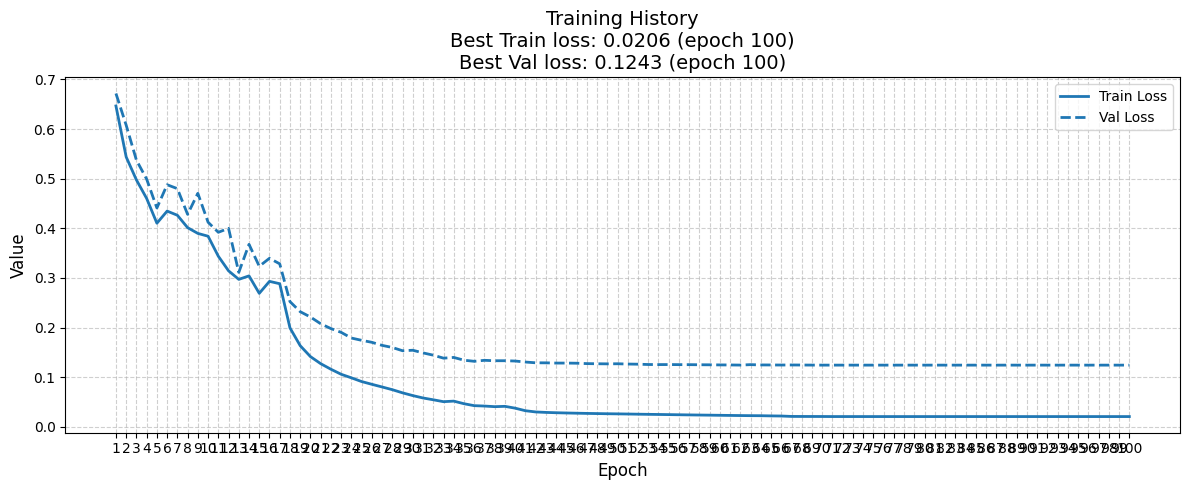

In [72]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

set_random_seed() # mi sa che non va
d_hist = d_model.fit(
    x=d_train,
    validation_data=d_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(d_hist)

In [82]:
try:
    l = d_model.evaluate(d_val)[0]
    name = f"./multi-agent-models/daily/daily_{'-'.join(str(u) for u in lstm_units)}_{'-'.join(str(h) for h in head_hidden_units)}_loss{str(round(l,4)).replace('.','-')}.h5"
    d_model.save_weights(name)
    print(f'Weights saved: {name}')
except NameError: pass

28/28 [==============================] - 2s 9ms/step - loss: 0.1243 - mae: 0.2436
Weights saved: ./multi-agent-models/daily/daily_64-64-64_64-32_loss0-1243.h5


In [83]:
d_model.summary()


Model: multi_agent_model_5
Layer (type)                       Output Shape                  Param #        
masking_5                           (None, 24, 22)                 0              
lstm_0                              (None, 24, 64)                 22272          
lstm_1                              (None, 24, 64)                 33024          
lstm_2                              (None, 64)                     33024          

PM10_head.dense_42                  (None, 64)                     4160           
PM10_head.dense_43                  (None, 32)                     2080           
PM10_head.dense_44                  (None, 1)                      33             

PM2.5_head.dense_45                 (None, 64)                     4160           
PM2.5_head.dense_46                 (None, 32)                     2080           
PM2.5_head.dense_47                 (None, 1)                      33             

Total params: 100,866
Trainable params: 100,866
Non-traina

In [91]:
def map_inputs(x, a, *rest):
    return (x, a),

d_results = d_model.predict(d_test.map(map_inputs)) # only pass sequence and agent id

55/55 [==============================] - 3s 11ms/step


In [92]:
d_agent_values = {
    'true': {},
    'predictions': {}
}
i = 0

for _, agent_ids, targets, station_ids, dates in d_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s, d in zip(agent_ids, targets, station_ids, dates):
        s_key = stations[s]
        a_key = a.decode('utf-8')
        if s_key not in d_agent_values['true']:
            d_agent_values['true'][s_key] = {}
            d_agent_values['predictions'][s_key] = {}
        if a_key not in d_agent_values['true'][s_key]:
            d_agent_values['true'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            d_agent_values['predictions'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            d_agent_values['true'][s_key][a_key].index.name = 'Date'
            d_agent_values['predictions'][s_key][a_key].index.name = 'Date'
        
        date_index = d.numpy().decode('utf-8')
        d_agent_values['true'][s_key][a_key].loc[pd.to_datetime(date_index)] = t
        d_agent_values['predictions'][s_key][a_key].loc[pd.to_datetime(date_index)] = d_results[i]
        i+=1

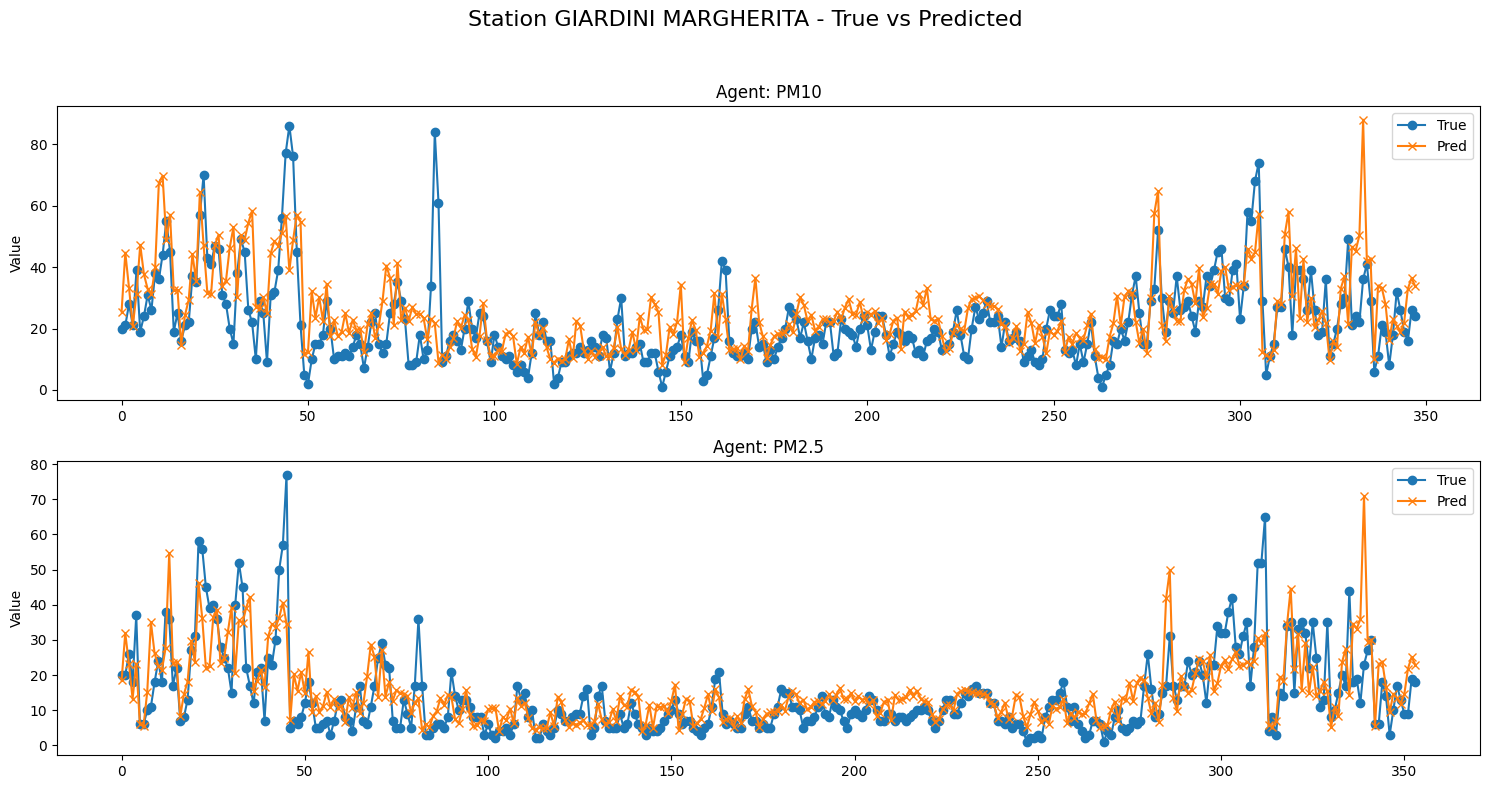

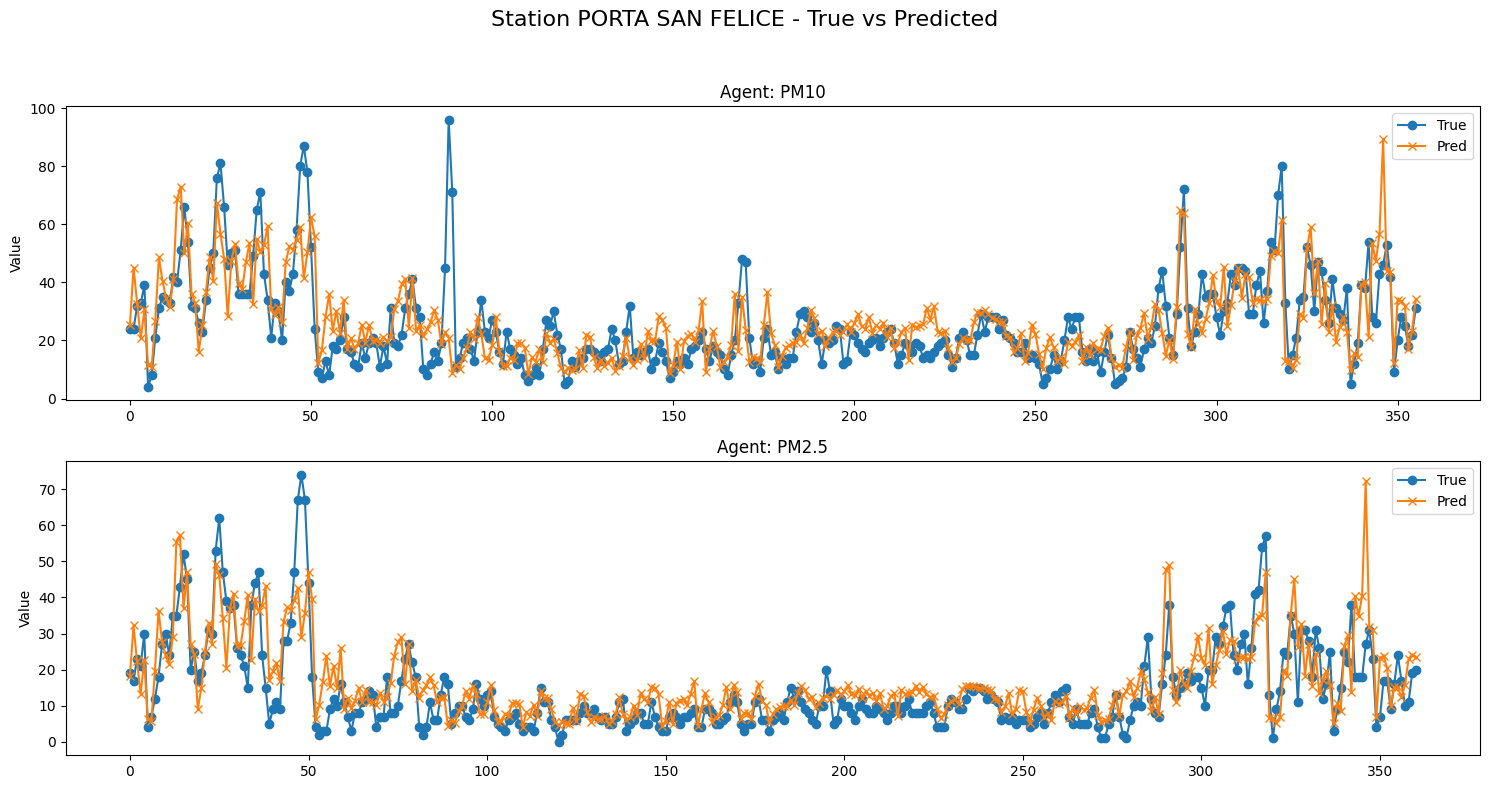

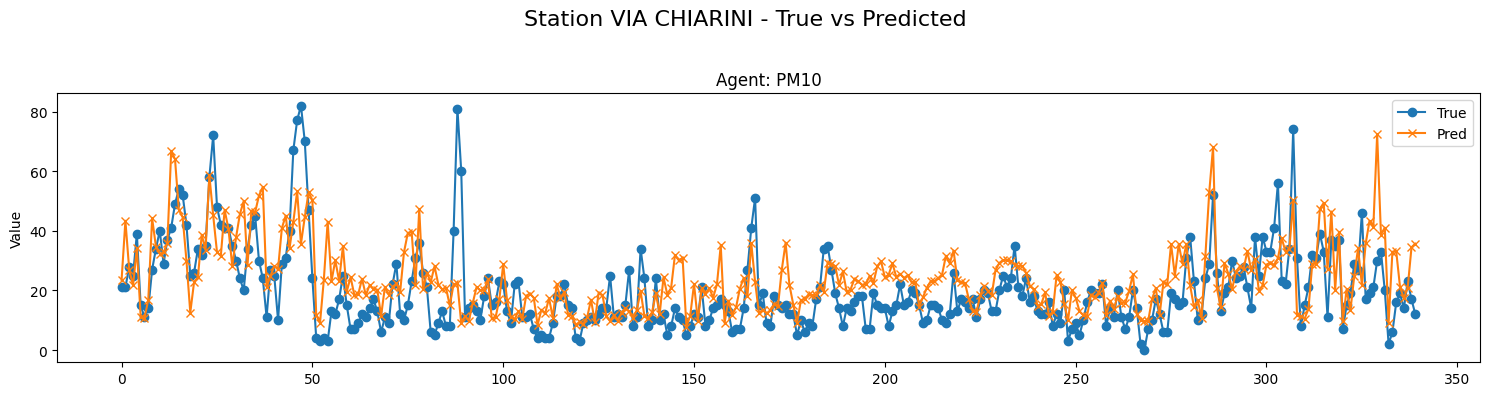

In [93]:
plot_predictions(d_agent_values, agent_distributions, max_elements_per_plot=999)

### Hourly

In [29]:
h_train, h_val, h_test = split_dataset(hourly_dataset, batch_size=256)

In [41]:
# from tensorflow_addons.optimizers import AdamW


lstm_units = (64, 64, 64)
head_hidden_units = (64, 32)

h_model = MultiAgentModel(
    input_shape=hourly_input_shape,
    task_ids=[agent for agent in agents if agent not in ('PM10','PM2.5')],
    lstm_units=lstm_units,
    head_hidden_units=head_hidden_units
)

h_model.compile(
    Adam(
        learning_rate=1e-2,
        # weight_decay=1e-5
        ),
    loss="mse",       # mean squared error for regression
    metrics=["mae"],  # mean absolute error
    weighted_metrics=[]
)

In [42]:
try:
    h_model.evaluate(h_val.take(1)) # init the model
    name = f"./multi-agent-models/hourly/hourly_{'-'.join(str(u) for u in lstm_units)}_{'-'.join(str(h) for h in head_hidden_units)}_loss0-2573.h5"
    print(f'Trying to load {name}')
    h_model.load_weights(name)
    print('Successfully loaded weights')
except (ValueError, FileNotFoundError) as e: 
    print(f'Failed loading weights.\n{e}')

1/1 [==============================] - 72s 72s/step - loss: 0.9828 - mae: 0.7824
Trying to load ./multi-agent-models/hourly/hourly_64-64-64_64-32_loss0-2573.h5
Successfully loaded weights


Epoch 1/100
1051/1051 [==============================] - 224s 141ms/step - loss: 0.3678 - mae: 0.4303 - val_loss: 0.3203 - val_mae: 0.4045 - lr: 0.0100
Epoch 2/100
1051/1051 [==============================] - 212s 137ms/step - loss: 0.3138 - mae: 0.3925 - val_loss: 0.3021 - val_mae: 0.3975 - lr: 0.0100
Epoch 3/100
1051/1051 [==============================] - 208s 135ms/step - loss: 0.2914 - mae: 0.3769 - val_loss: 0.2849 - val_mae: 0.3823 - lr: 0.0100
Epoch 4/100
1051/1051 [==============================] - 209s 137ms/step - loss: 0.2772 - mae: 0.3671 - val_loss: 0.2738 - val_mae: 0.3735 - lr: 0.0100
Epoch 5/100
1051/1051 [==============================] - 207s 135ms/step - loss: 0.2656 - mae: 0.3594 - val_loss: 0.2714 - val_mae: 0.3693 - lr: 0.0100
Epoch 6/100
1051/1051 [==============================] - 211s 138ms/step - loss: 0.2593 - mae: 0.3556 - val_loss: 0.2666 - val_mae: 0.3656 - lr: 0.0100
Epoch 7/100
1051/1051 [==============================] - 209s 137ms/step - loss: 0.2559 

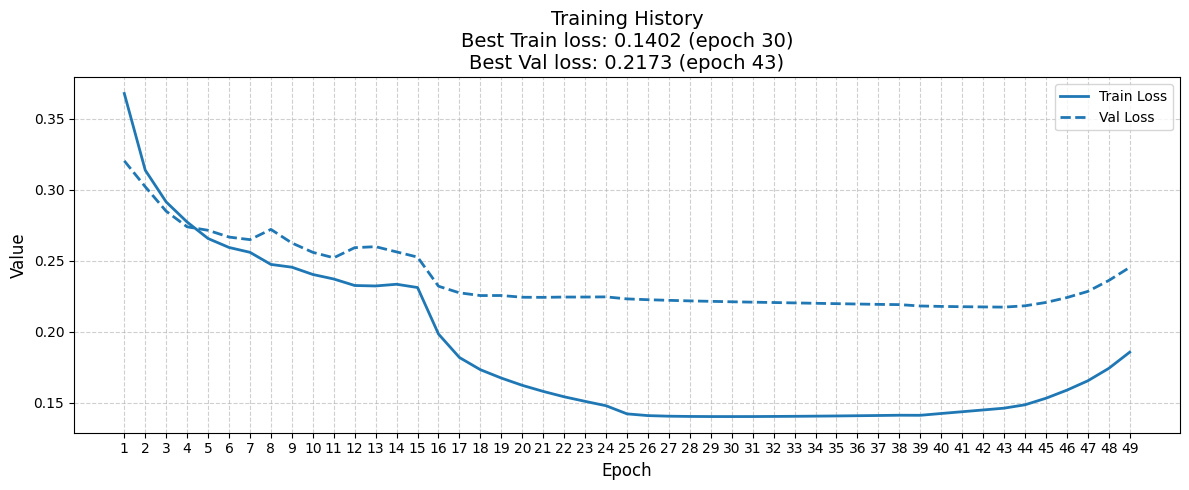

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        verbose=0,
        min_delta=0.001
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=6,
        verbose=1,
        restore_best_weights=True
    )
]

set_random_seed() # mi sa che non va
h_hist = h_model.fit(
    x=h_train,
    validation_data=h_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(h_hist)

In [207]:
try:
    l = h_model.evaluate(h_val)[0] # loss of the val set
    name = f"./multi-agent-models/hourly/hourly_{'-'.join(str(u) for u in lstm_units)}_{'-'.join(str(h) for h in head_hidden_units)}_loss{str(round(l,4)).replace('.','-')}.h5"
    h_model.save_weights(name)
    print(f'Weights saved: {name}')
except NameError: pass

KeyboardInterrupt: 

In [211]:
h_model.summary()


Model: multi_agent_model_19
Layer (type)                       Output Shape                  Param #        
masking_19                          (None, 3, 24)                  0              
lstm_0                              (None, 3, 64)                  22784          
lstm_1                              (None, 3, 64)                  33024          
lstm_2                              (None, 64)                     33024          

C6H6_head.dense_209                 (None, 64)                     4160           
C6H6_head.dense_210                 (None, 32)                     2080           
C6H6_head.dense_211                 (None, 1)                      33             

CO_head.dense_212                   (None, 64)                     4160           
CO_head.dense_213                   (None, 32)                     2080           
CO_head.dense_214                   (None, 1)                      33             

NO2_head.dense_215                  (None, 64)           

In [32]:
def map_inputs(x, a, *rest):
    return (x, a),

h_results = h_model.predict(h_test.map(map_inputs)) # only pass sequence and agent id

234/234 [==============================] - 81s 60ms/step


In [33]:
h_agent_values = {
    'true': {},
    'predictions': {}
}
i = 0

for _, agent_ids, targets, station_ids, dates in h_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s, d in zip(agent_ids, targets, station_ids, dates):
        s_key = stations[s]
        a_key = a.decode('utf-8')
        if s_key not in h_agent_values['true']:
            h_agent_values['true'][s_key] = {}
            h_agent_values['predictions'][s_key] = {}
        if a_key not in h_agent_values['true'][s_key]:
            h_agent_values['true'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            h_agent_values['predictions'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            h_agent_values['true'][s_key][a_key].index.name = 'Date'
            h_agent_values['predictions'][s_key][a_key].index.name = 'Date'
        
        date_index = d.numpy().decode('utf-8')
        h_agent_values['true'][s_key][a_key].loc[pd.to_datetime(date_index)] = t
        h_agent_values['predictions'][s_key][a_key].loc[pd.to_datetime(date_index)] = h_results[i]
        i+=1

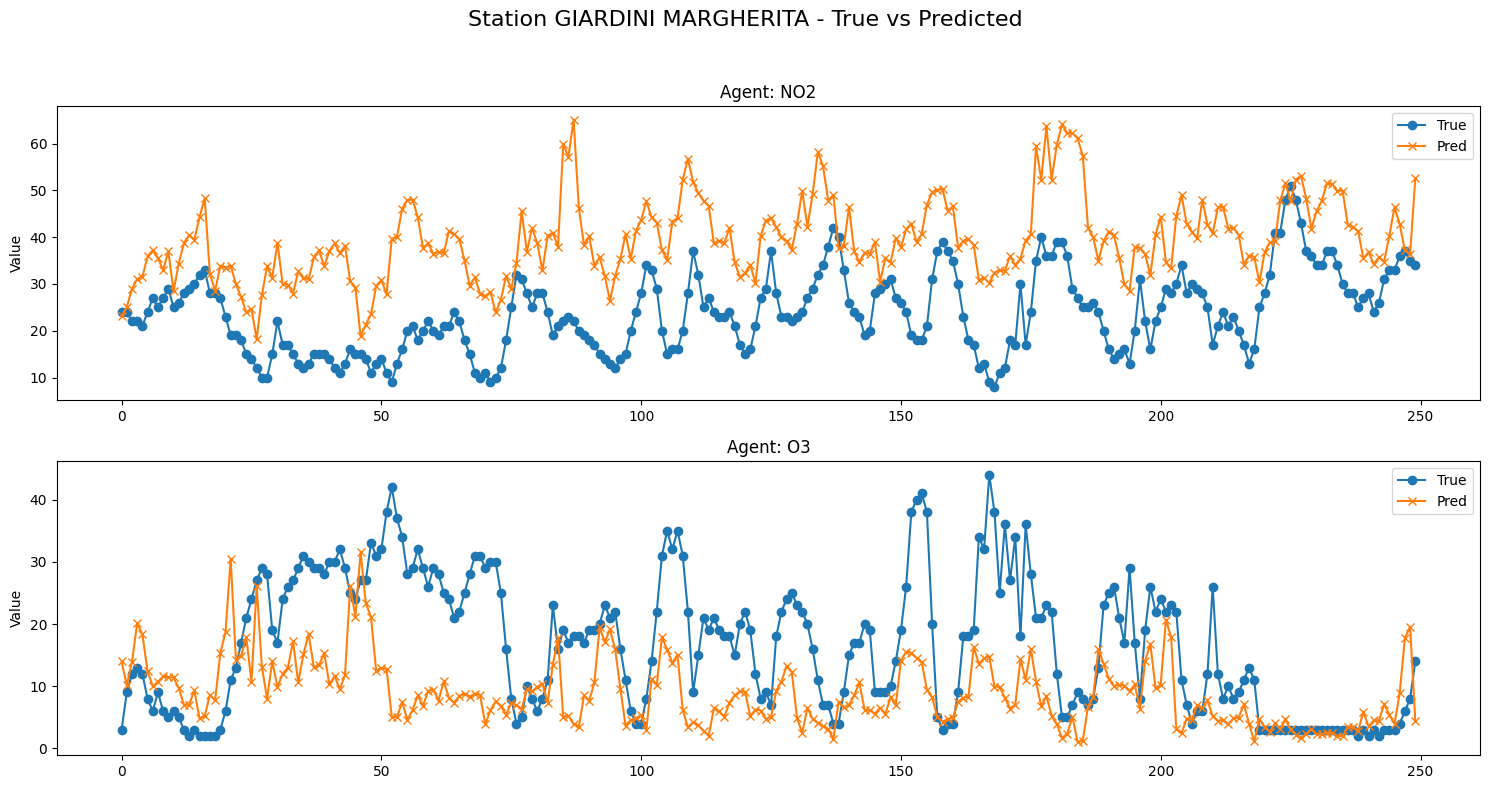

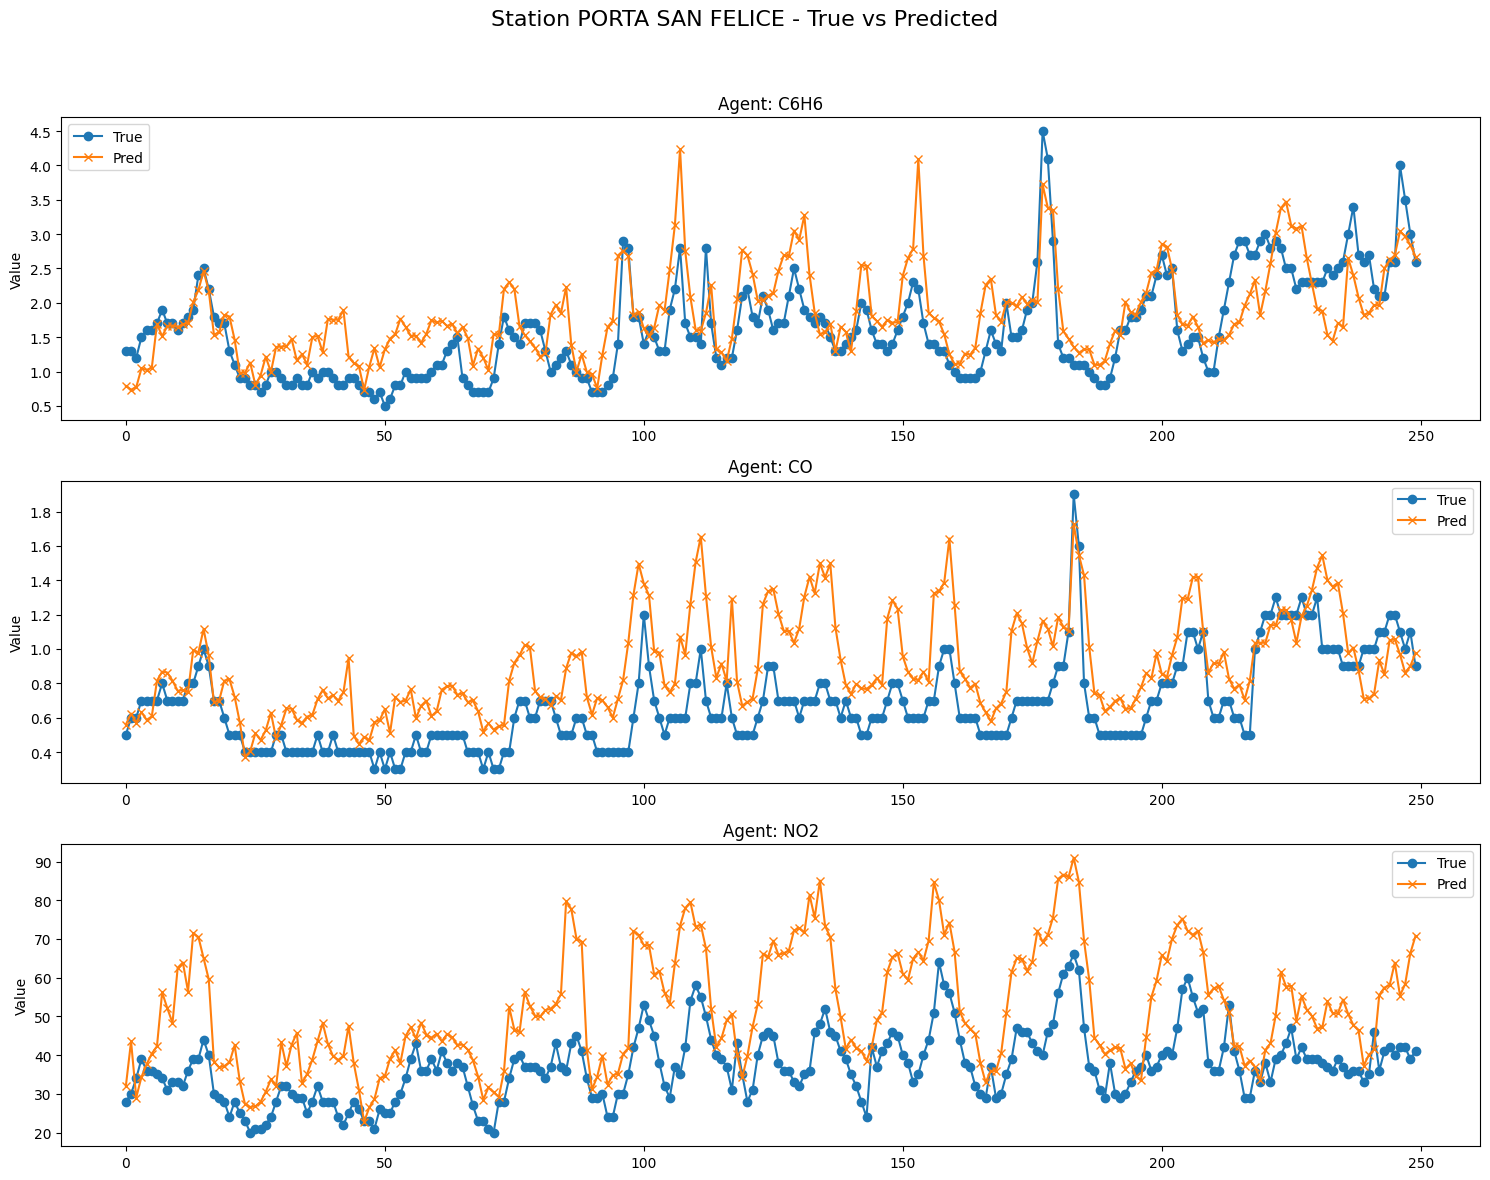

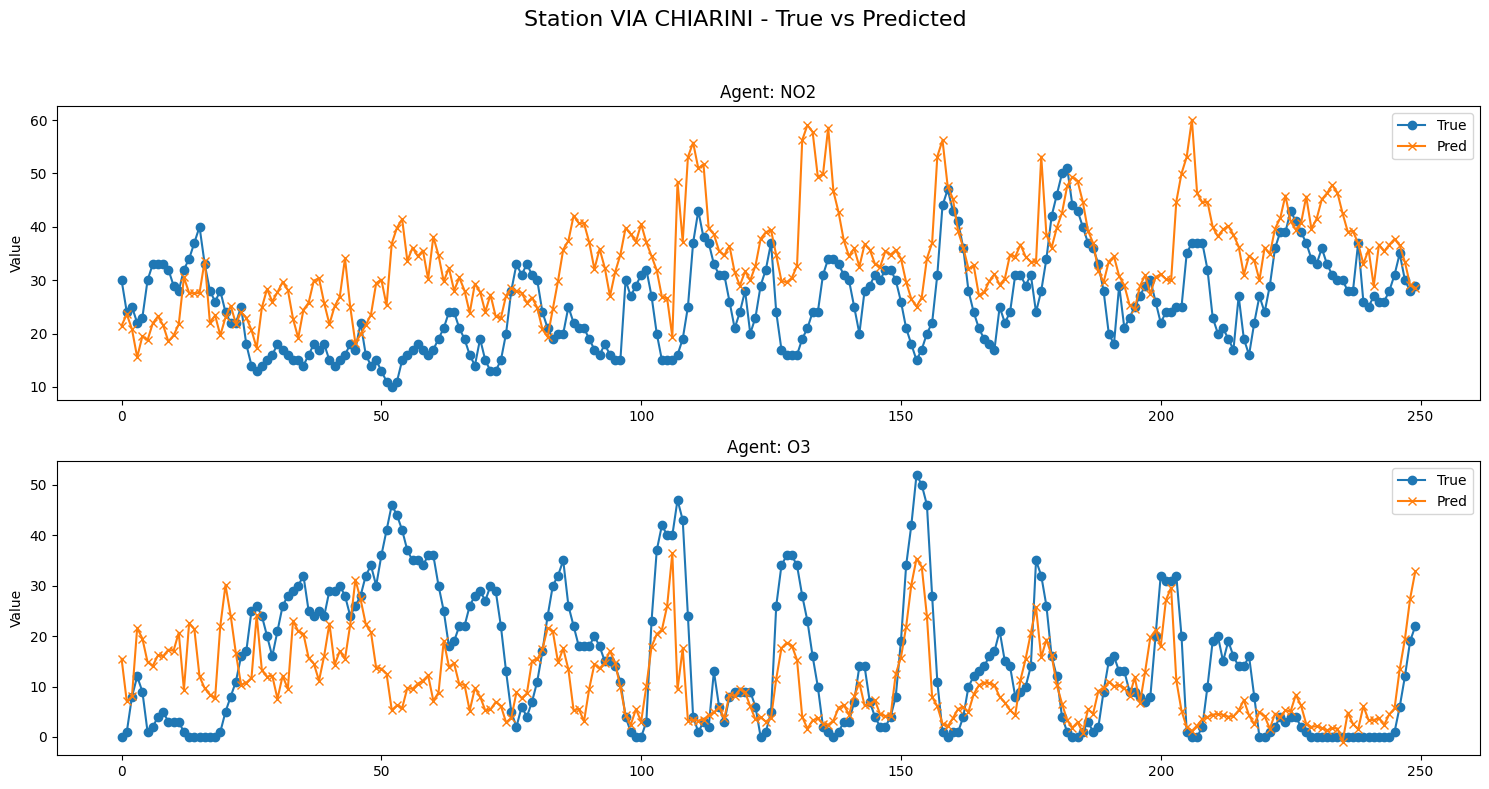

In [34]:
plot_predictions(
    h_agent_values, 
    agent_distributions, 
    max_elements_per_plot=250
)

## Air Quality Index

In [94]:
agent_values = {
    'predictions': {},
    'true': {}
}
# we should merge here the results of the two models, such to have a singular dict for every station
for station in stations:
    agent_values['predictions'][station] = {}
    agent_values['true'][station] = {}
    for agent in h_agent_values['predictions'][station]:
        agent_values['predictions'][station][agent] = (h_agent_values['predictions'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0)
        agent_values['true'][station][agent] = (h_agent_values['true'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0) # should not be needed
    for agent in d_agent_values['predictions'][station]:
        agent_values['predictions'][station][agent] = (d_agent_values['predictions'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0)
        agent_values['true'][station][agent] = (d_agent_values['true'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0) # should not be needed

for station in stations:
    print(
          f"{station}:\n"
          f"  preds: {agent_values['predictions'][station].keys()}\n"
          f"  true: {agent_values['true'][station].keys()}"
    )
    for a in agent_values['predictions'][station]:
        if len(agent_values['predictions'][station][a]) != len(agent_values['true'][station][a]):
            print(f'Inconsistent lenghts for {a} in {station}')

GIARDINI MARGHERITA:
  preds: dict_keys(['NO2', 'O3', 'PM10', 'PM2.5'])
  true: dict_keys(['NO2', 'O3', 'PM10', 'PM2.5'])
PORTA SAN FELICE:
  preds: dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
  true: dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
VIA CHIARINI:
  preds: dict_keys(['NO2', 'O3', 'PM10'])
  true: dict_keys(['NO2', 'O3', 'PM10'])


In [95]:
predictions = agent_values['predictions']
true_values = agent_values['true']

pred_AQIs_daily = {s: {agent: get_AQI(predictions[s][agent], agent=agent, period='day', value_column='Agent_value',) for agent in predictions[s].keys()} for s in predictions}
pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')
pred_AQIs_hourly = {s: {agent: get_AQI(predictions[s][agent],agent=agent,period='hour', value_column='Agent_value',include_hourly_pm=False) for agent in predictions[s].keys()} for s in predictions}
pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')
true_AQIs_daily = {s: {agent: get_AQI(true_values[s][agent], agent=agent, period='day', value_column='Agent_value',) for agent in true_values[s].keys()} for s in true_values}
true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')
true_AQIs_hourly = {s: {agent: get_AQI(true_values[s][agent],agent=agent,period='hour', value_column='Agent_value',include_hourly_pm=False) for agent in true_values[s].keys()} for s in true_values}
true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')
AQI_diff_daily = {}
AQI_diff_hourly = {}
for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

### Hourly

Station GIARDINI MARGHERITA AQI:


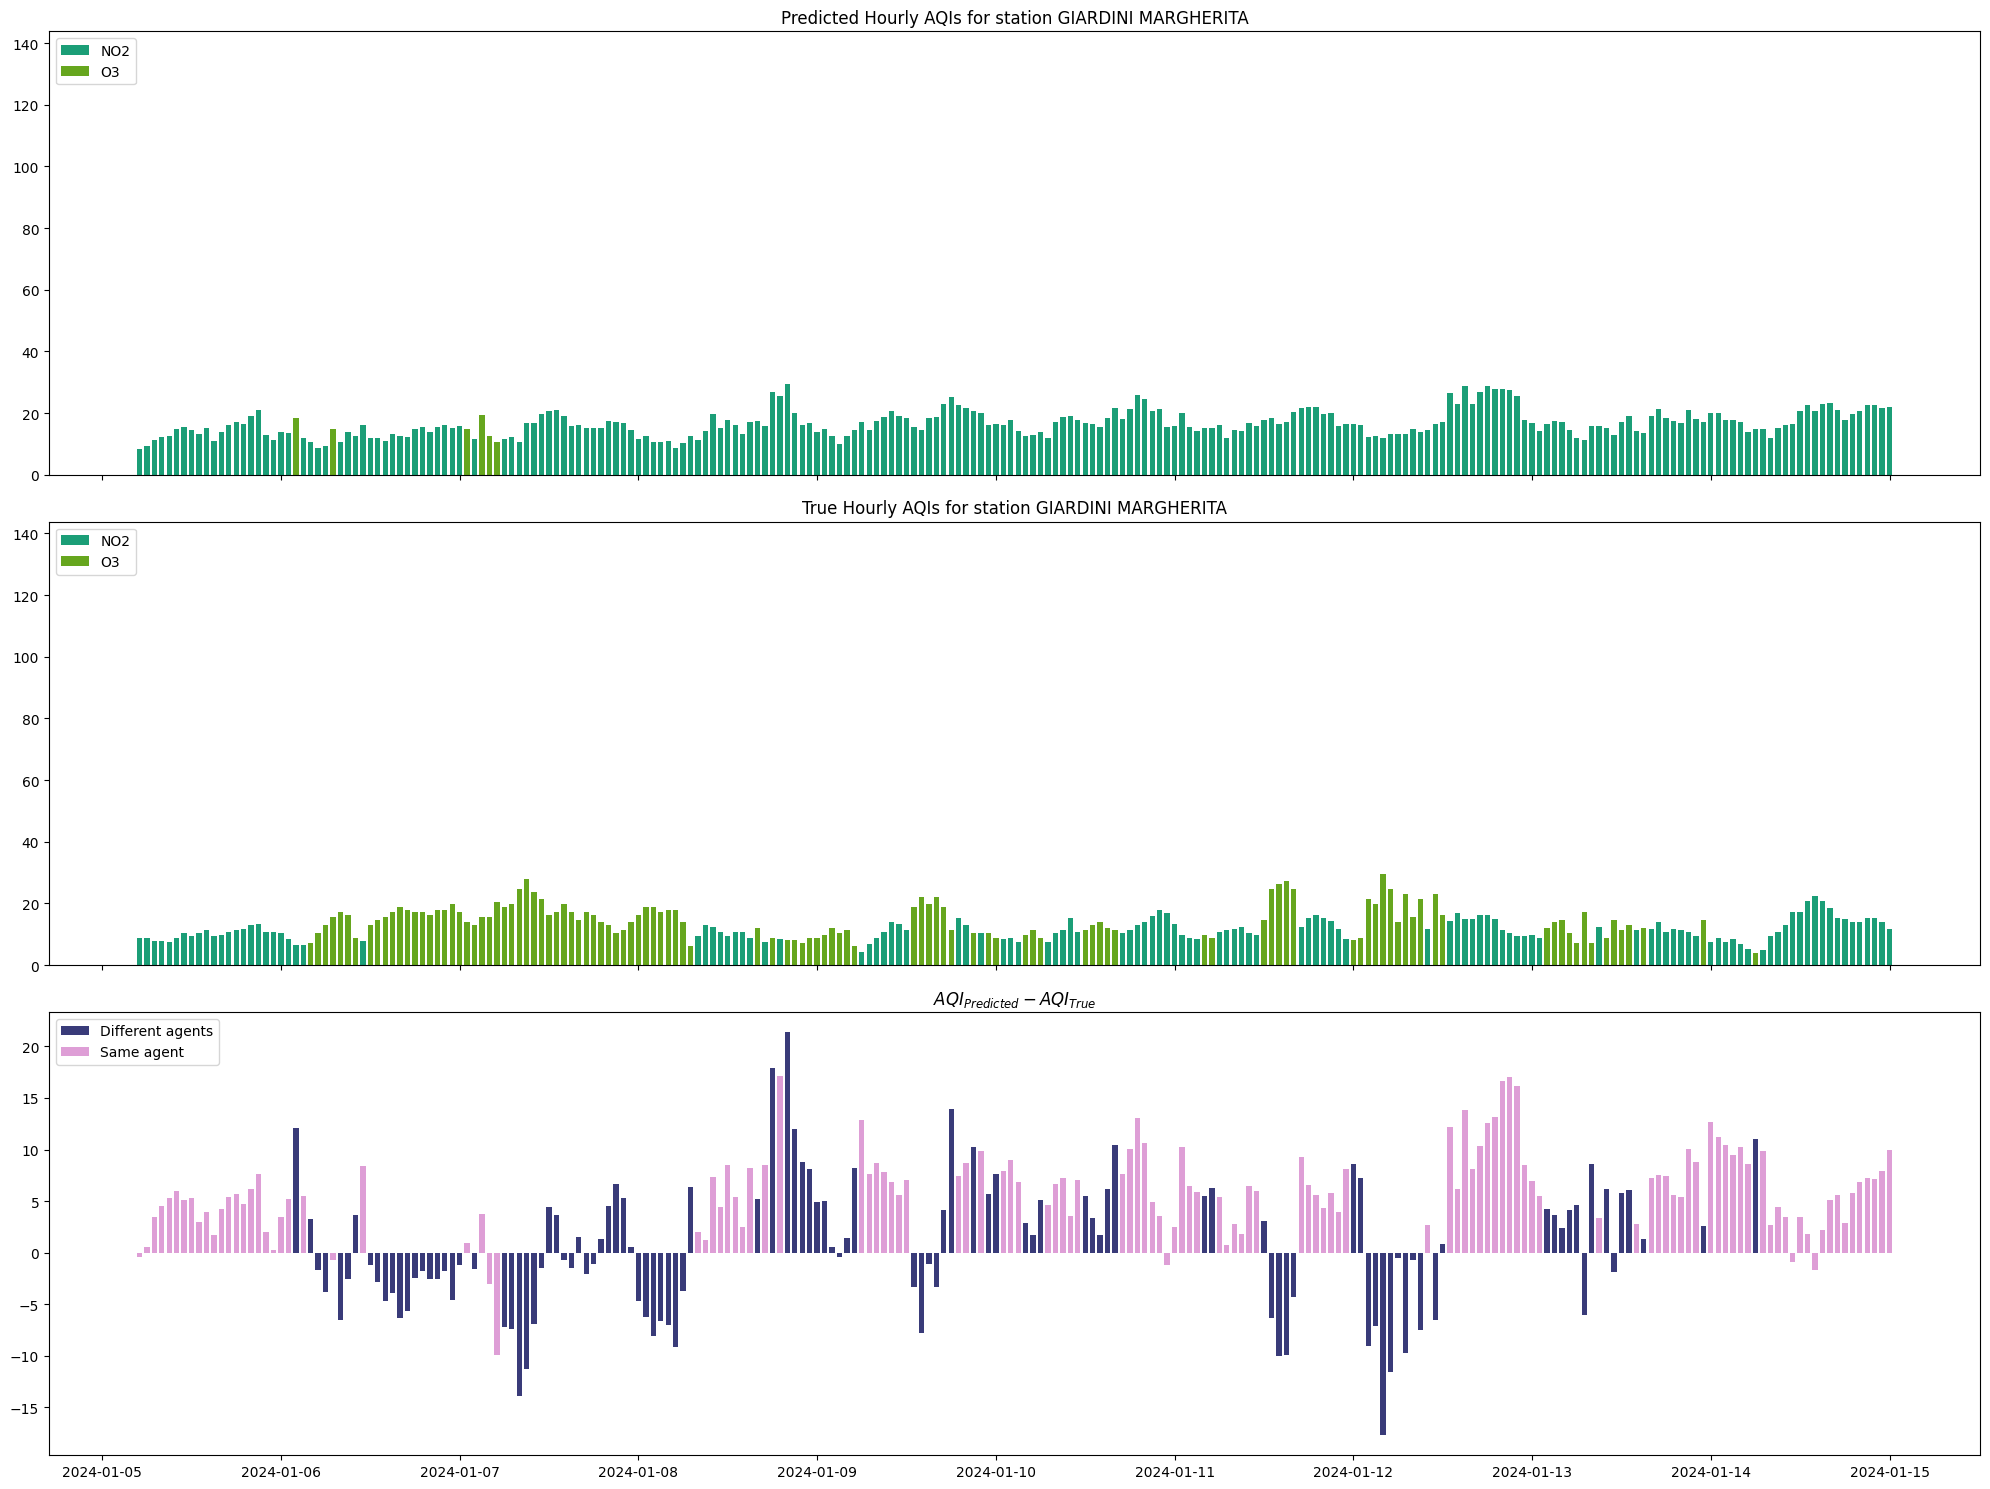

Station PORTA SAN FELICE AQI:


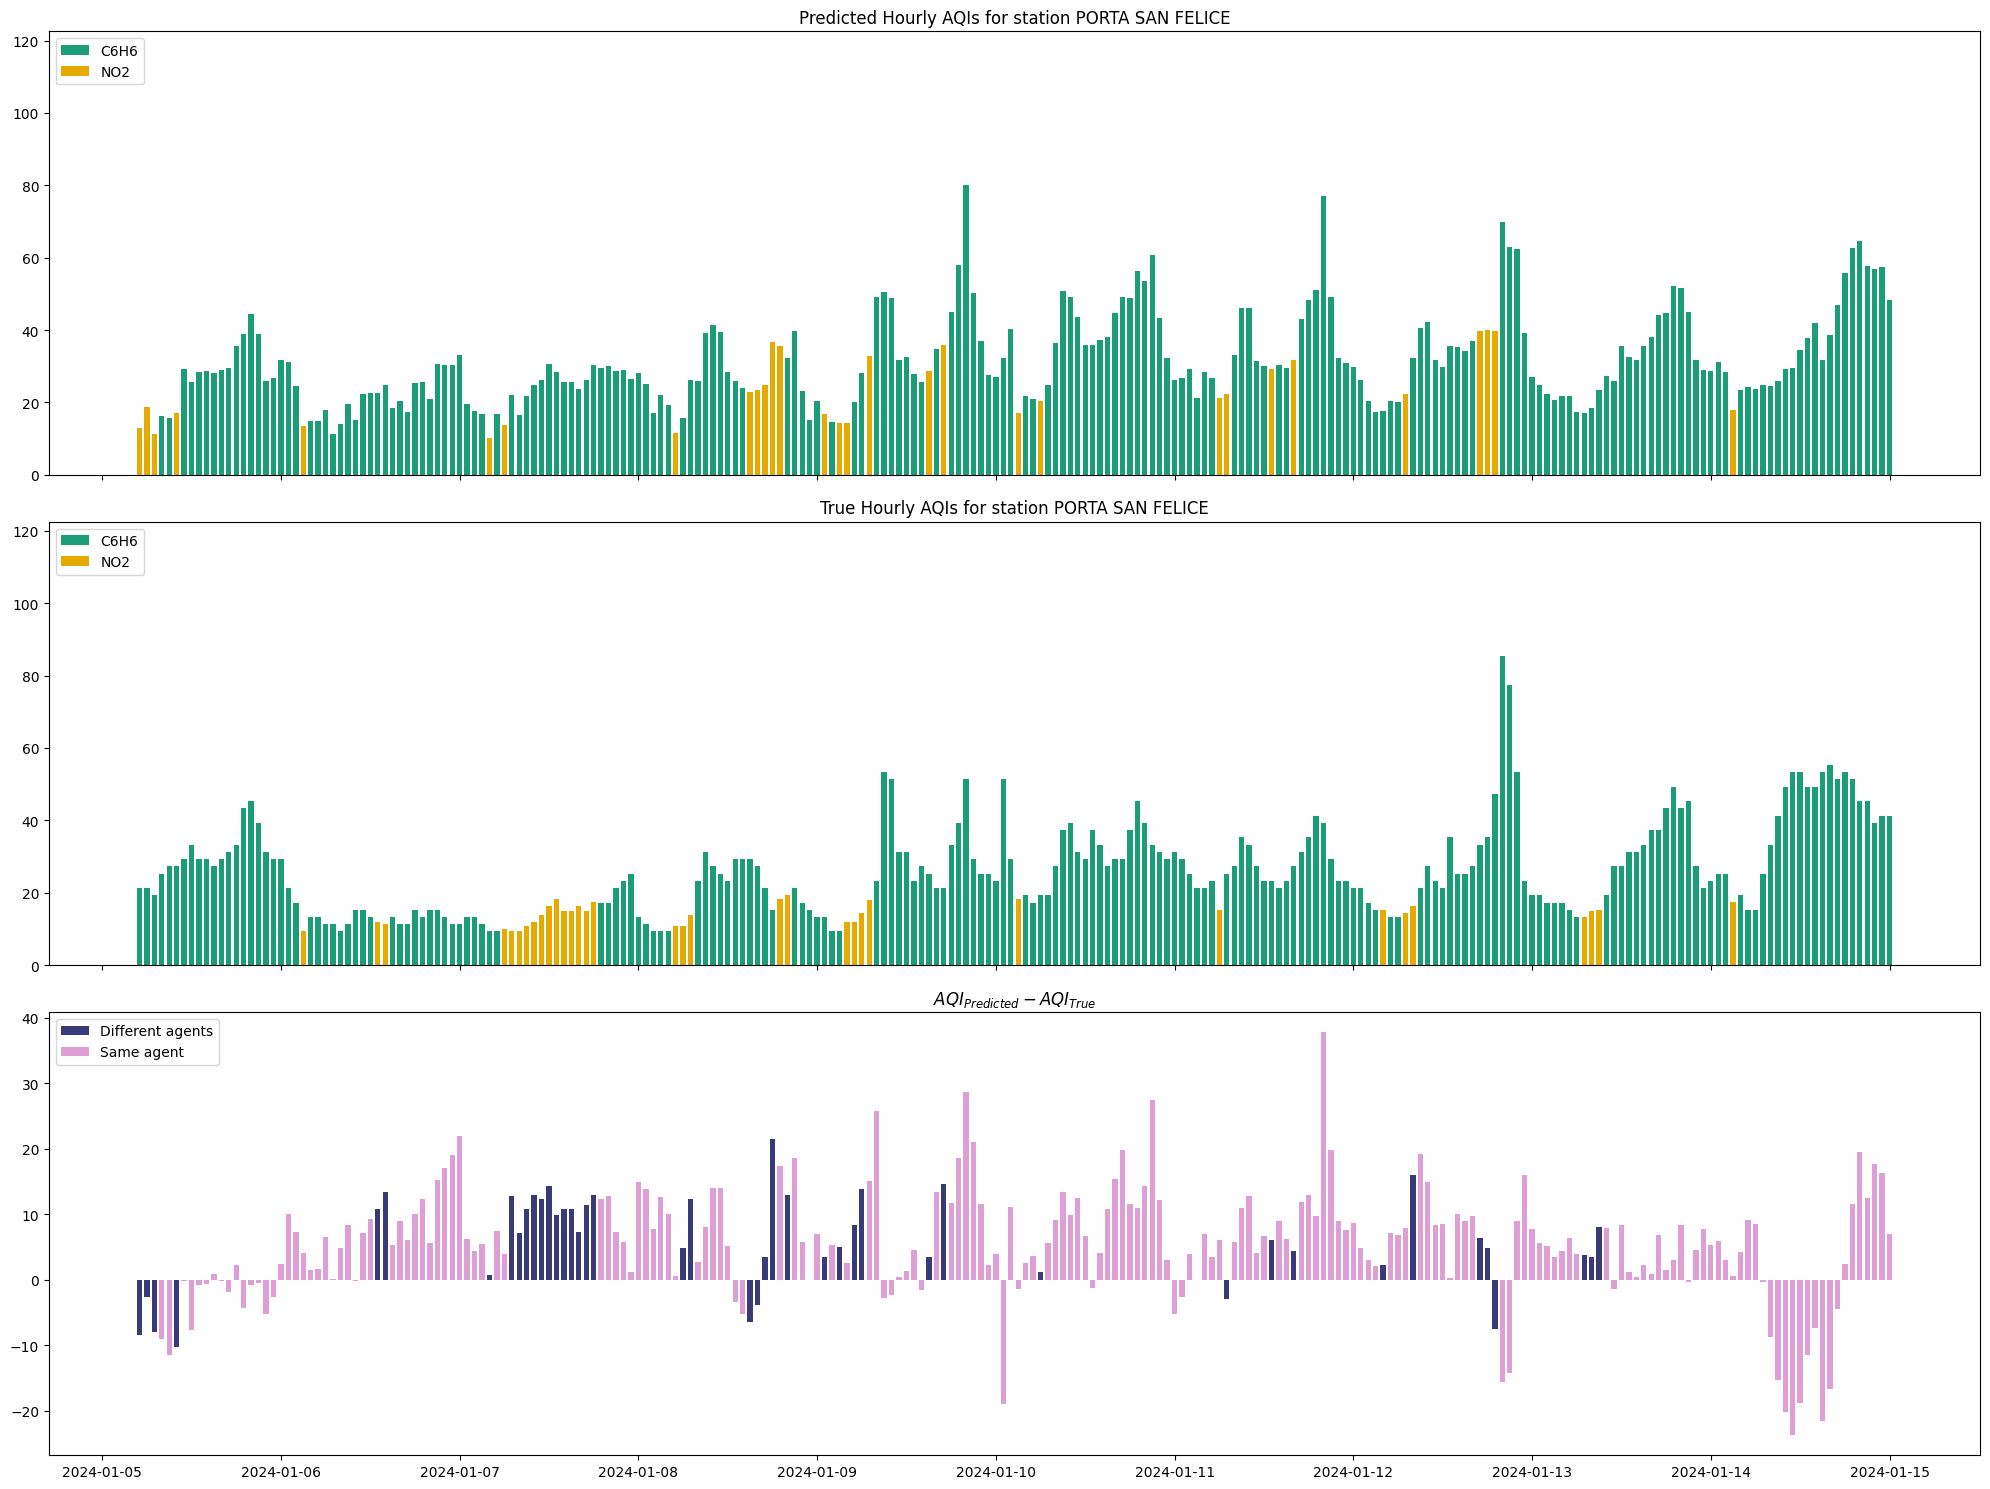

Station VIA CHIARINI AQI:


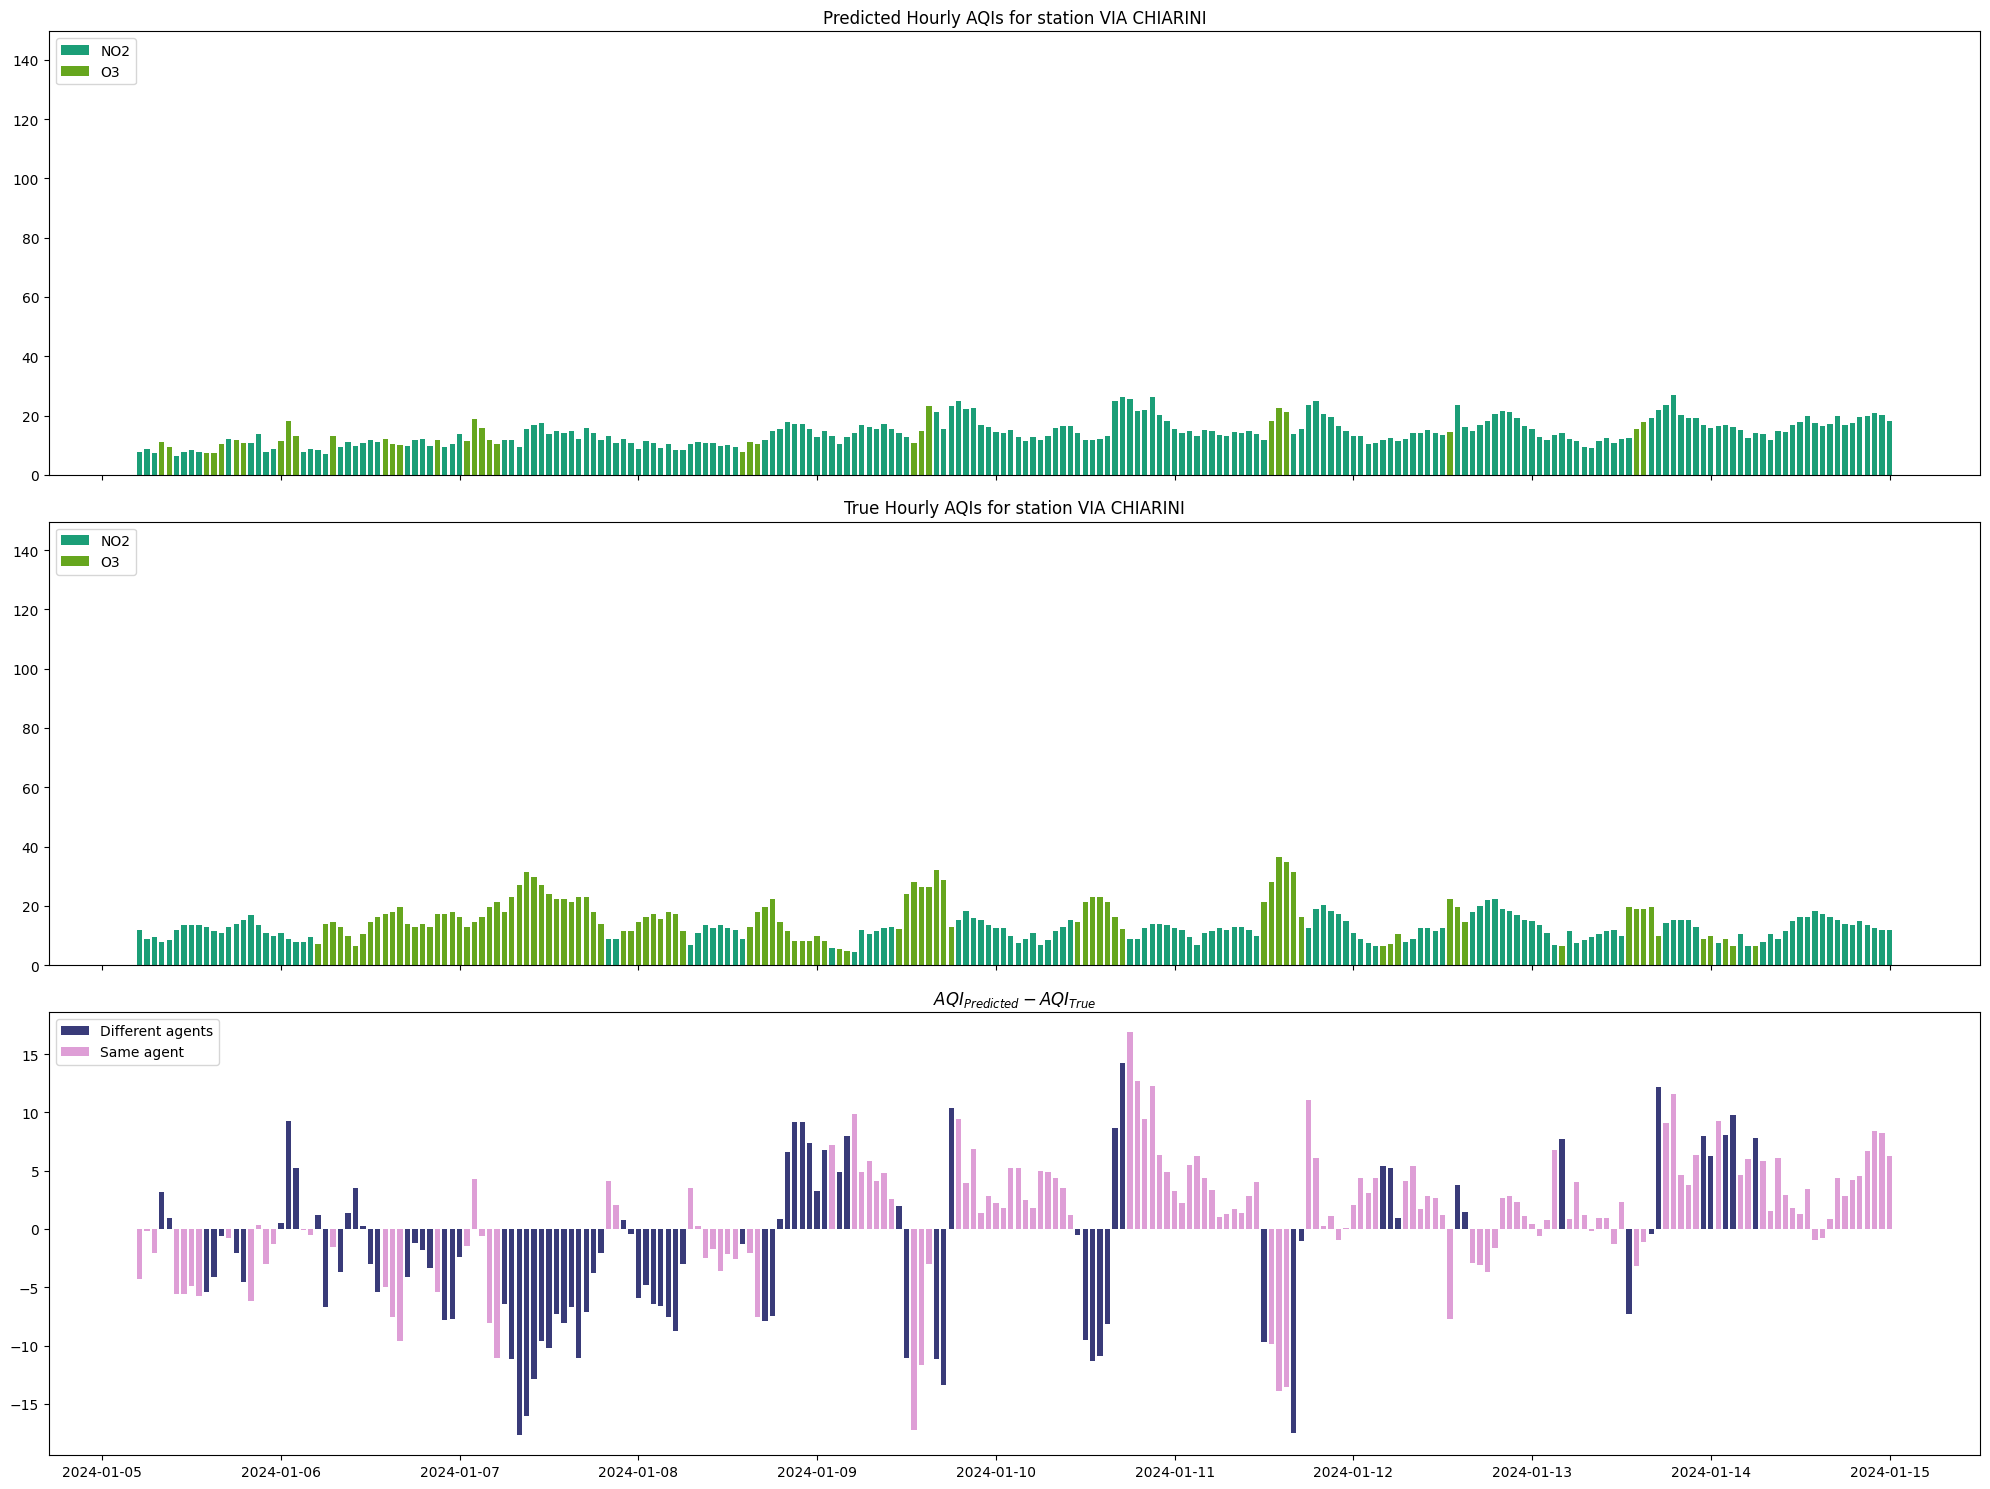

In [96]:
start=datetime(2024,1,1)
end=datetime(2024,1,15)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_hourly[station]['AQI'].max(),true_AQI_hourly[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        figsize=(20, 5), s=start, e=end, ylims=ylims)

Station GIARDINI MARGHERITA Hourly


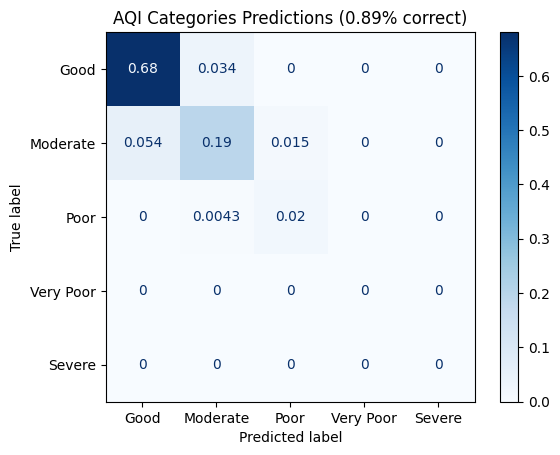

---------------------------------------------
> Absolute Mean AQI Difference: 8.38
> Positive Average AQI Difference: 7.87
> Negative Average AQI Difference: -9.07
> Percentage of Positive Differences: 57.30%
> Percentage of Negative Differences: 42.49%
> Percentage of Agent Values:
   - Same agent: 85.58
   - Different agents: 14.42
Station PORTA SAN FELICE Hourly


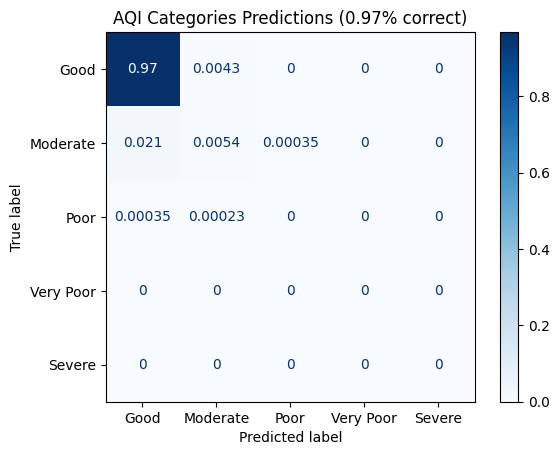

---------------------------------------------
> Absolute Mean AQI Difference: 6.76
> Positive Average AQI Difference: 6.28
> Negative Average AQI Difference: -7.35
> Percentage of Positive Differences: 54.99%
> Percentage of Negative Differences: 44.78%
> Percentage of Agent Values:
   - Same agent: 62.34
   - Different agents: 37.66
Station VIA CHIARINI Hourly


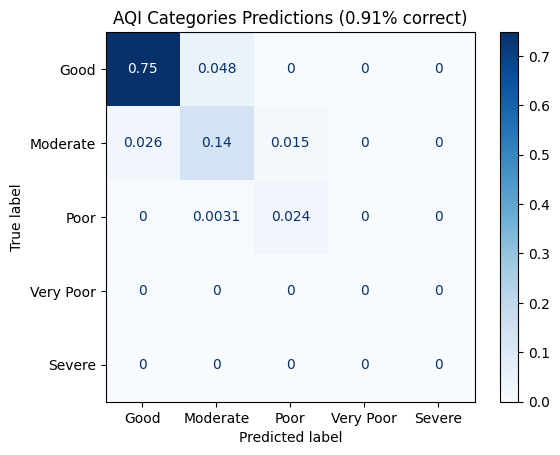

---------------------------------------------
> Absolute Mean AQI Difference: 8.17
> Positive Average AQI Difference: 8.82
> Negative Average AQI Difference: -6.84
> Percentage of Positive Differences: 67.06%
> Percentage of Negative Differences: 32.59%
> Percentage of Agent Values:
   - Same agent: 85.48
   - Different agents: 14.52


In [97]:
for station in pred_AQI_hourly:
    print('=============================================')
    print(f'Station {station} Hourly')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_hourly[station], true_AQI_hourly[station], categories=AQI_CATEGORIES)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

### Daily

Station GIARDINI MARGHERITA AQI:


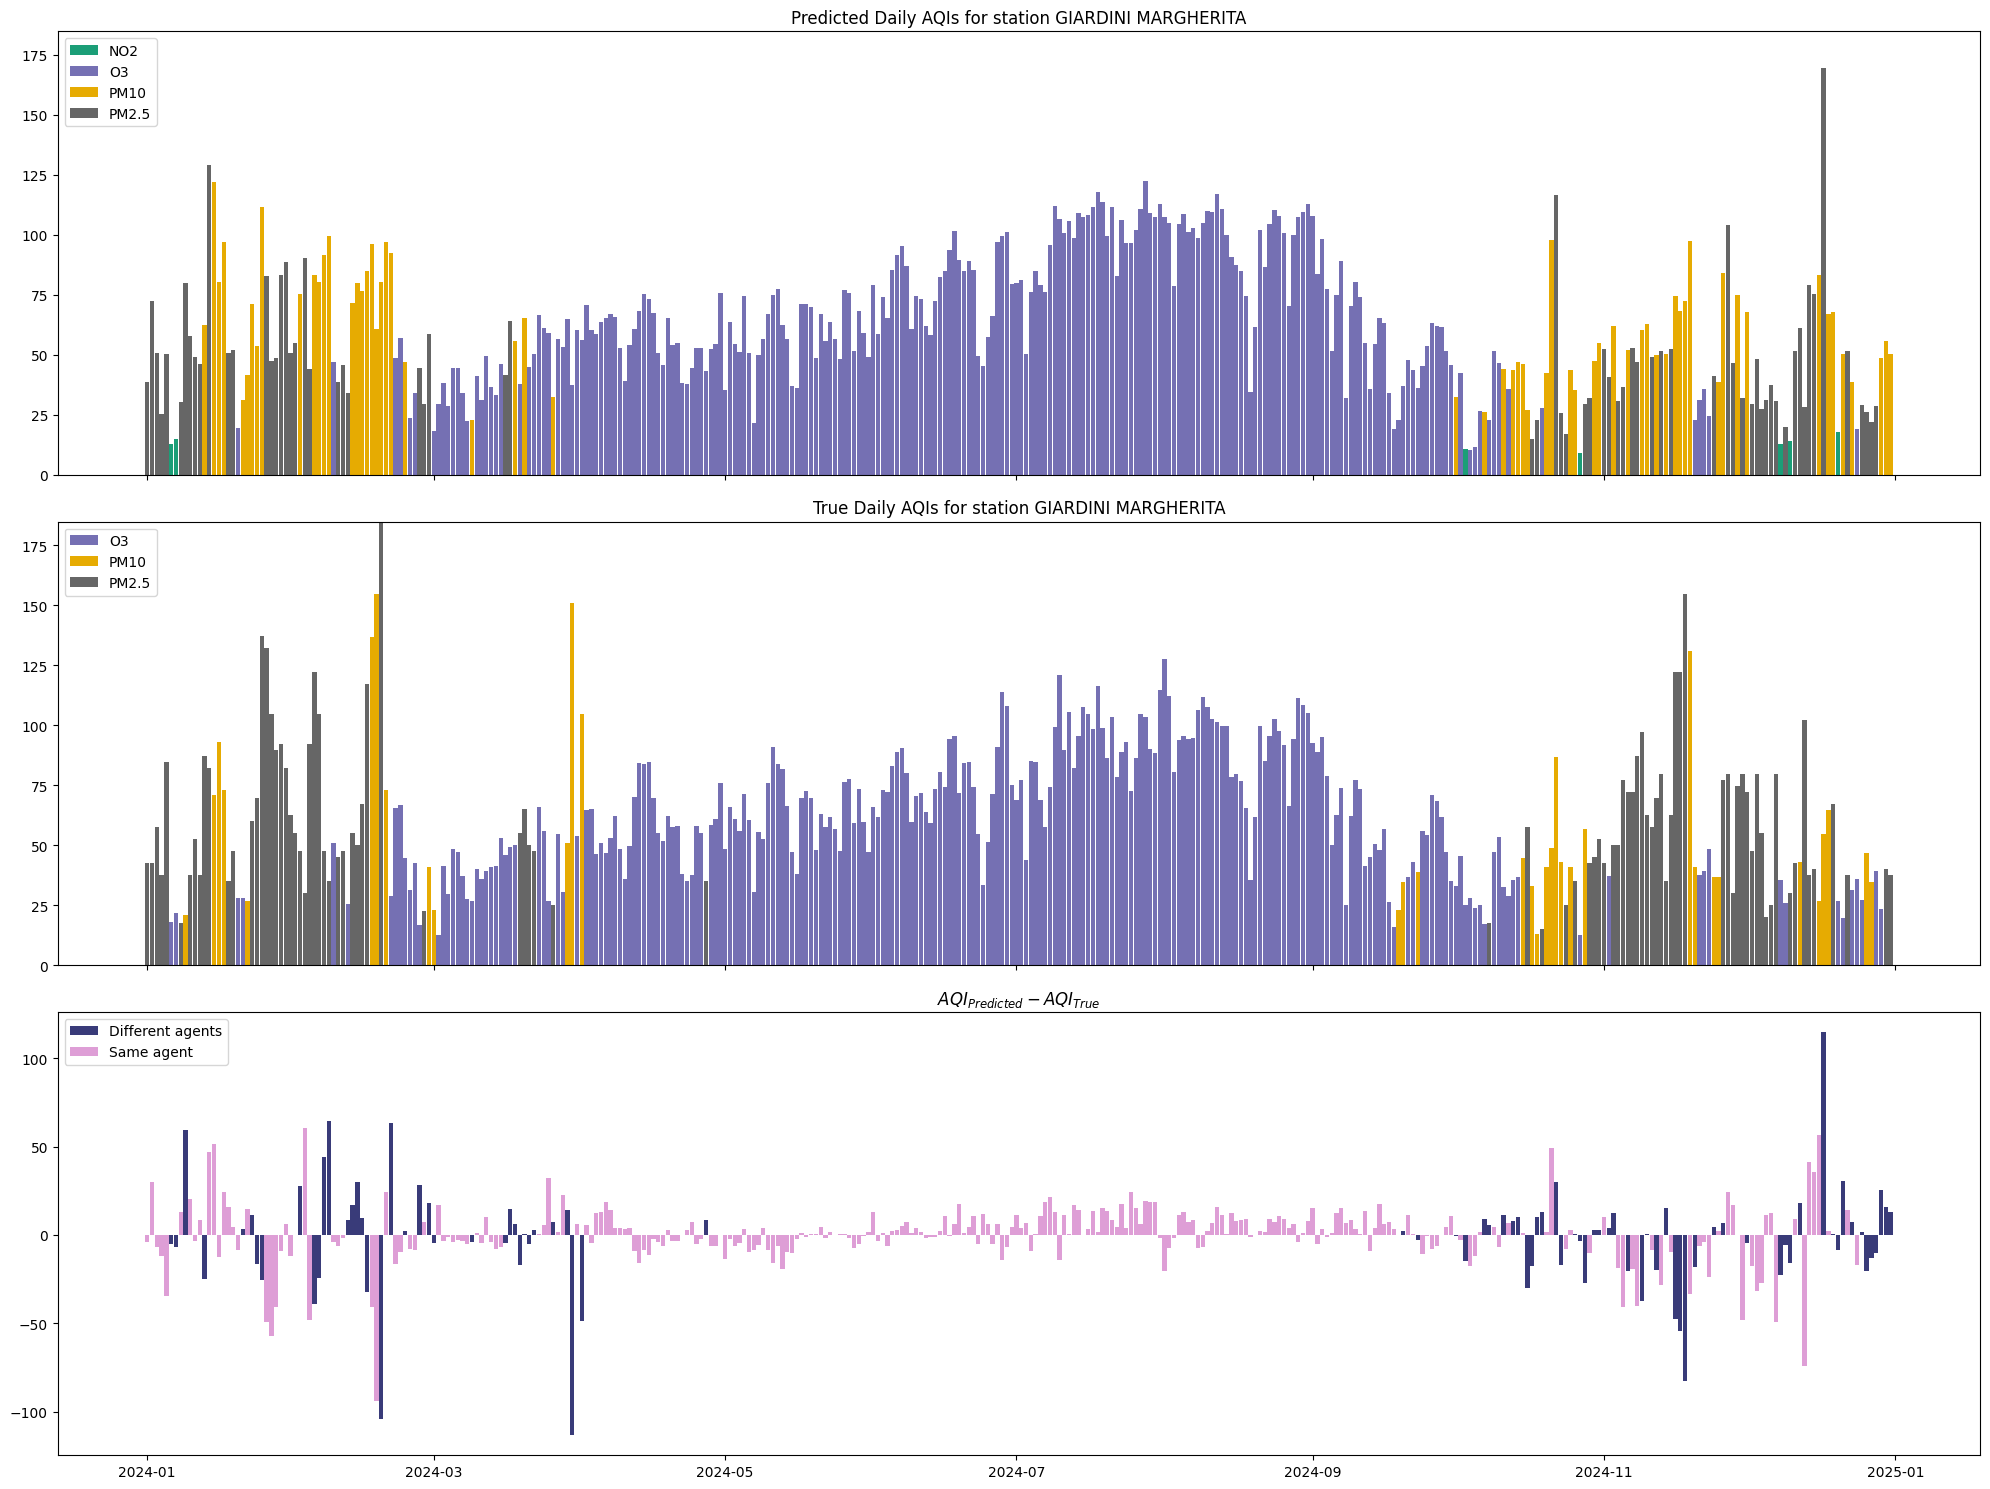

Station PORTA SAN FELICE AQI:


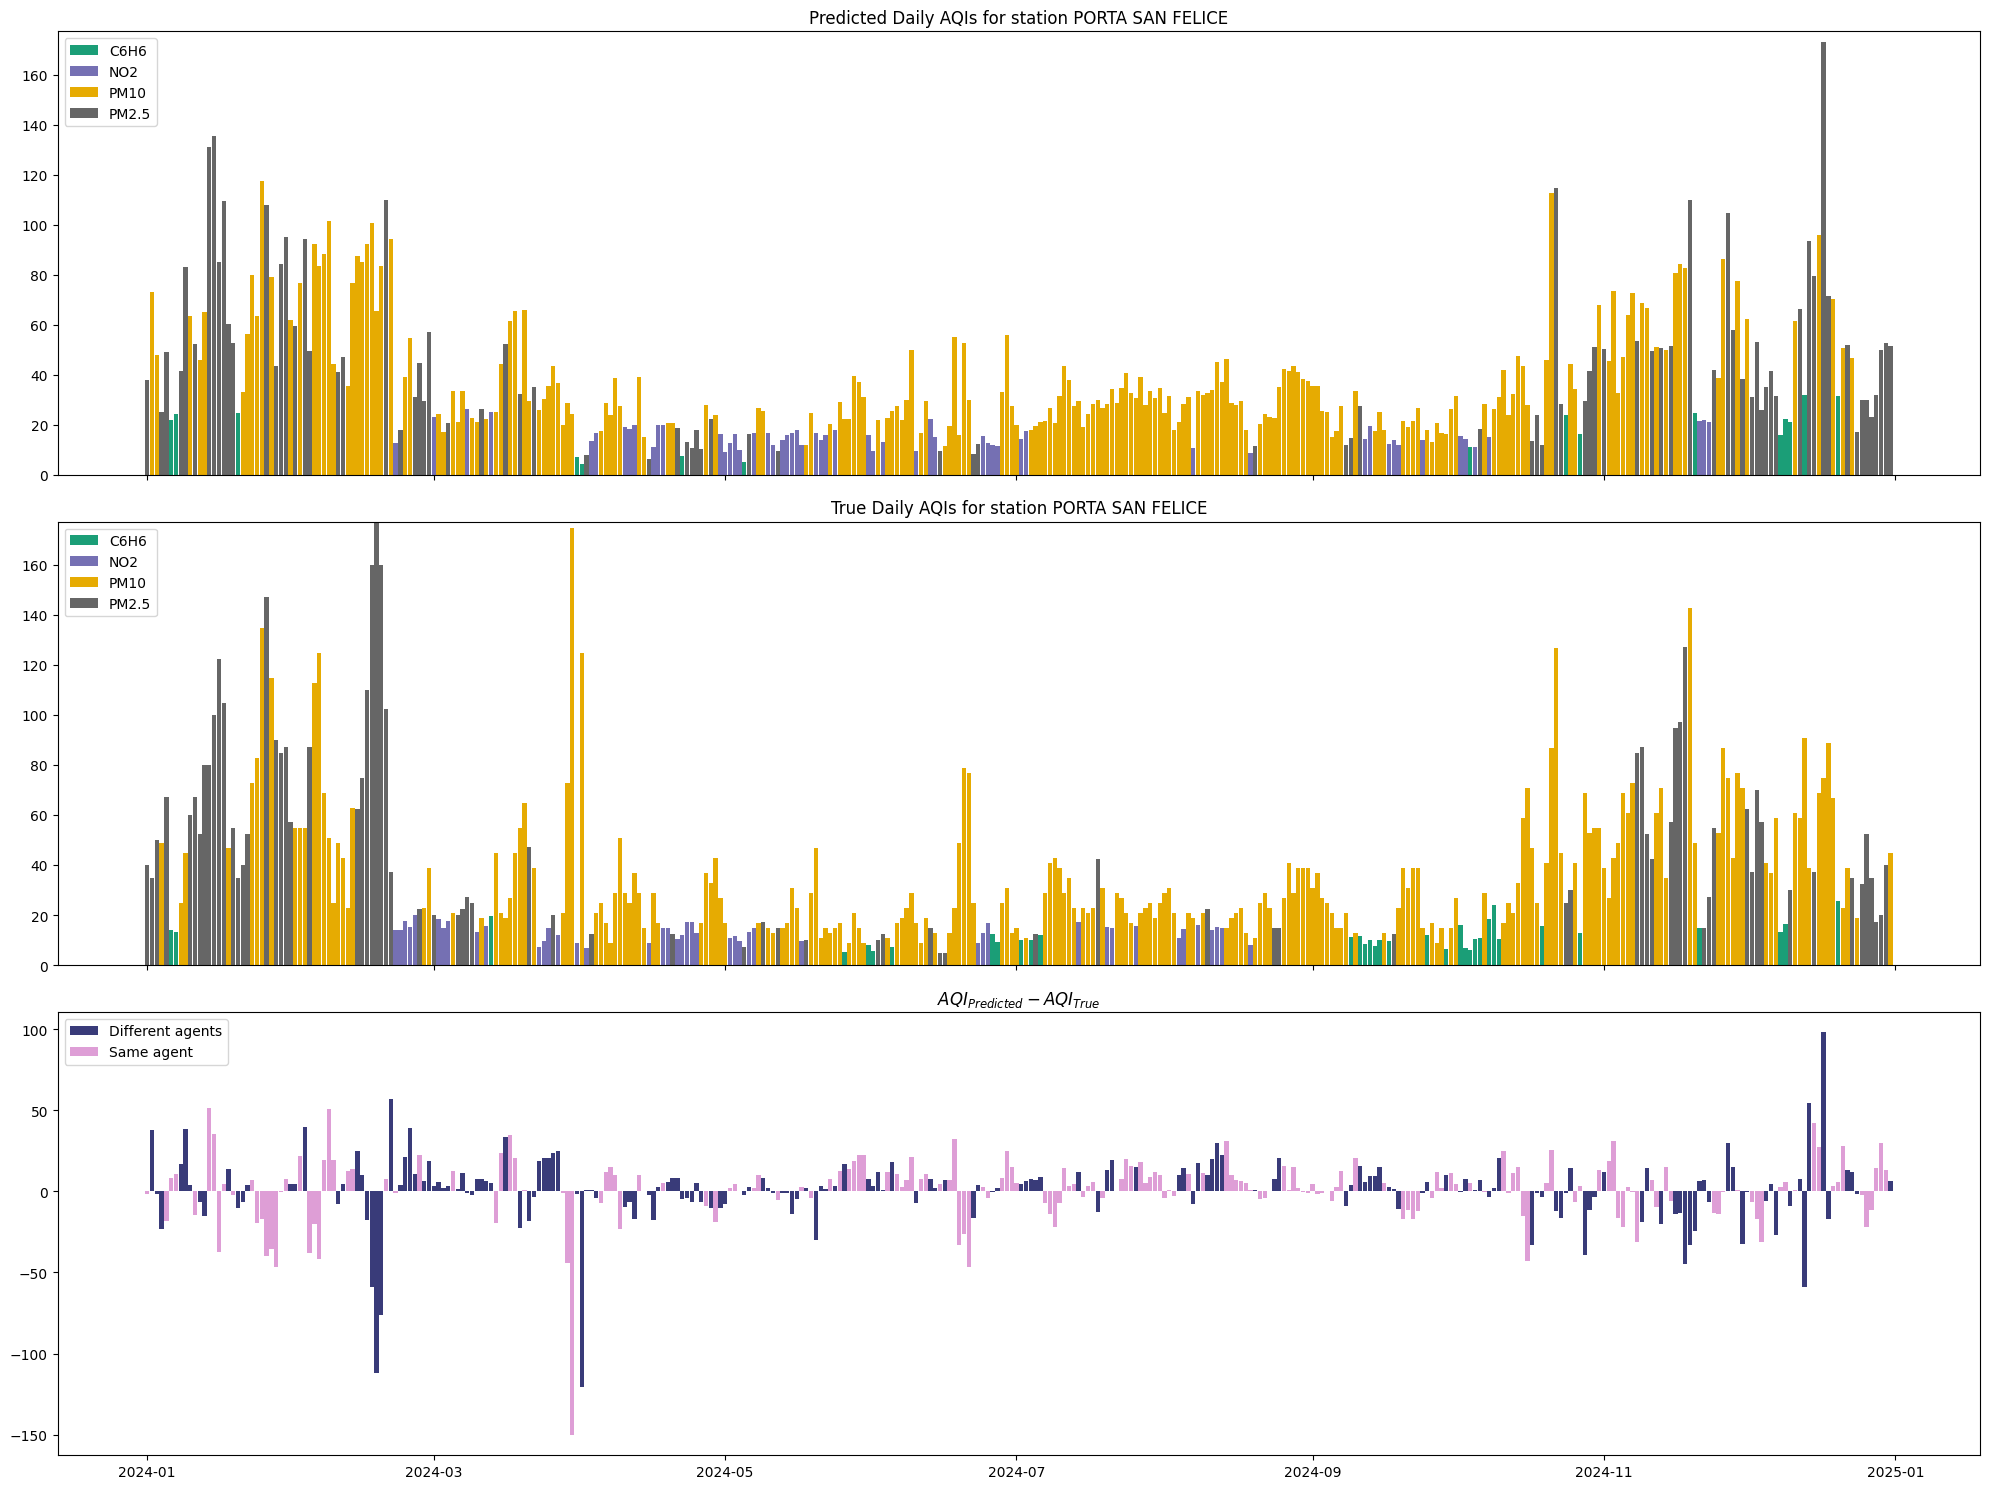

Station VIA CHIARINI AQI:


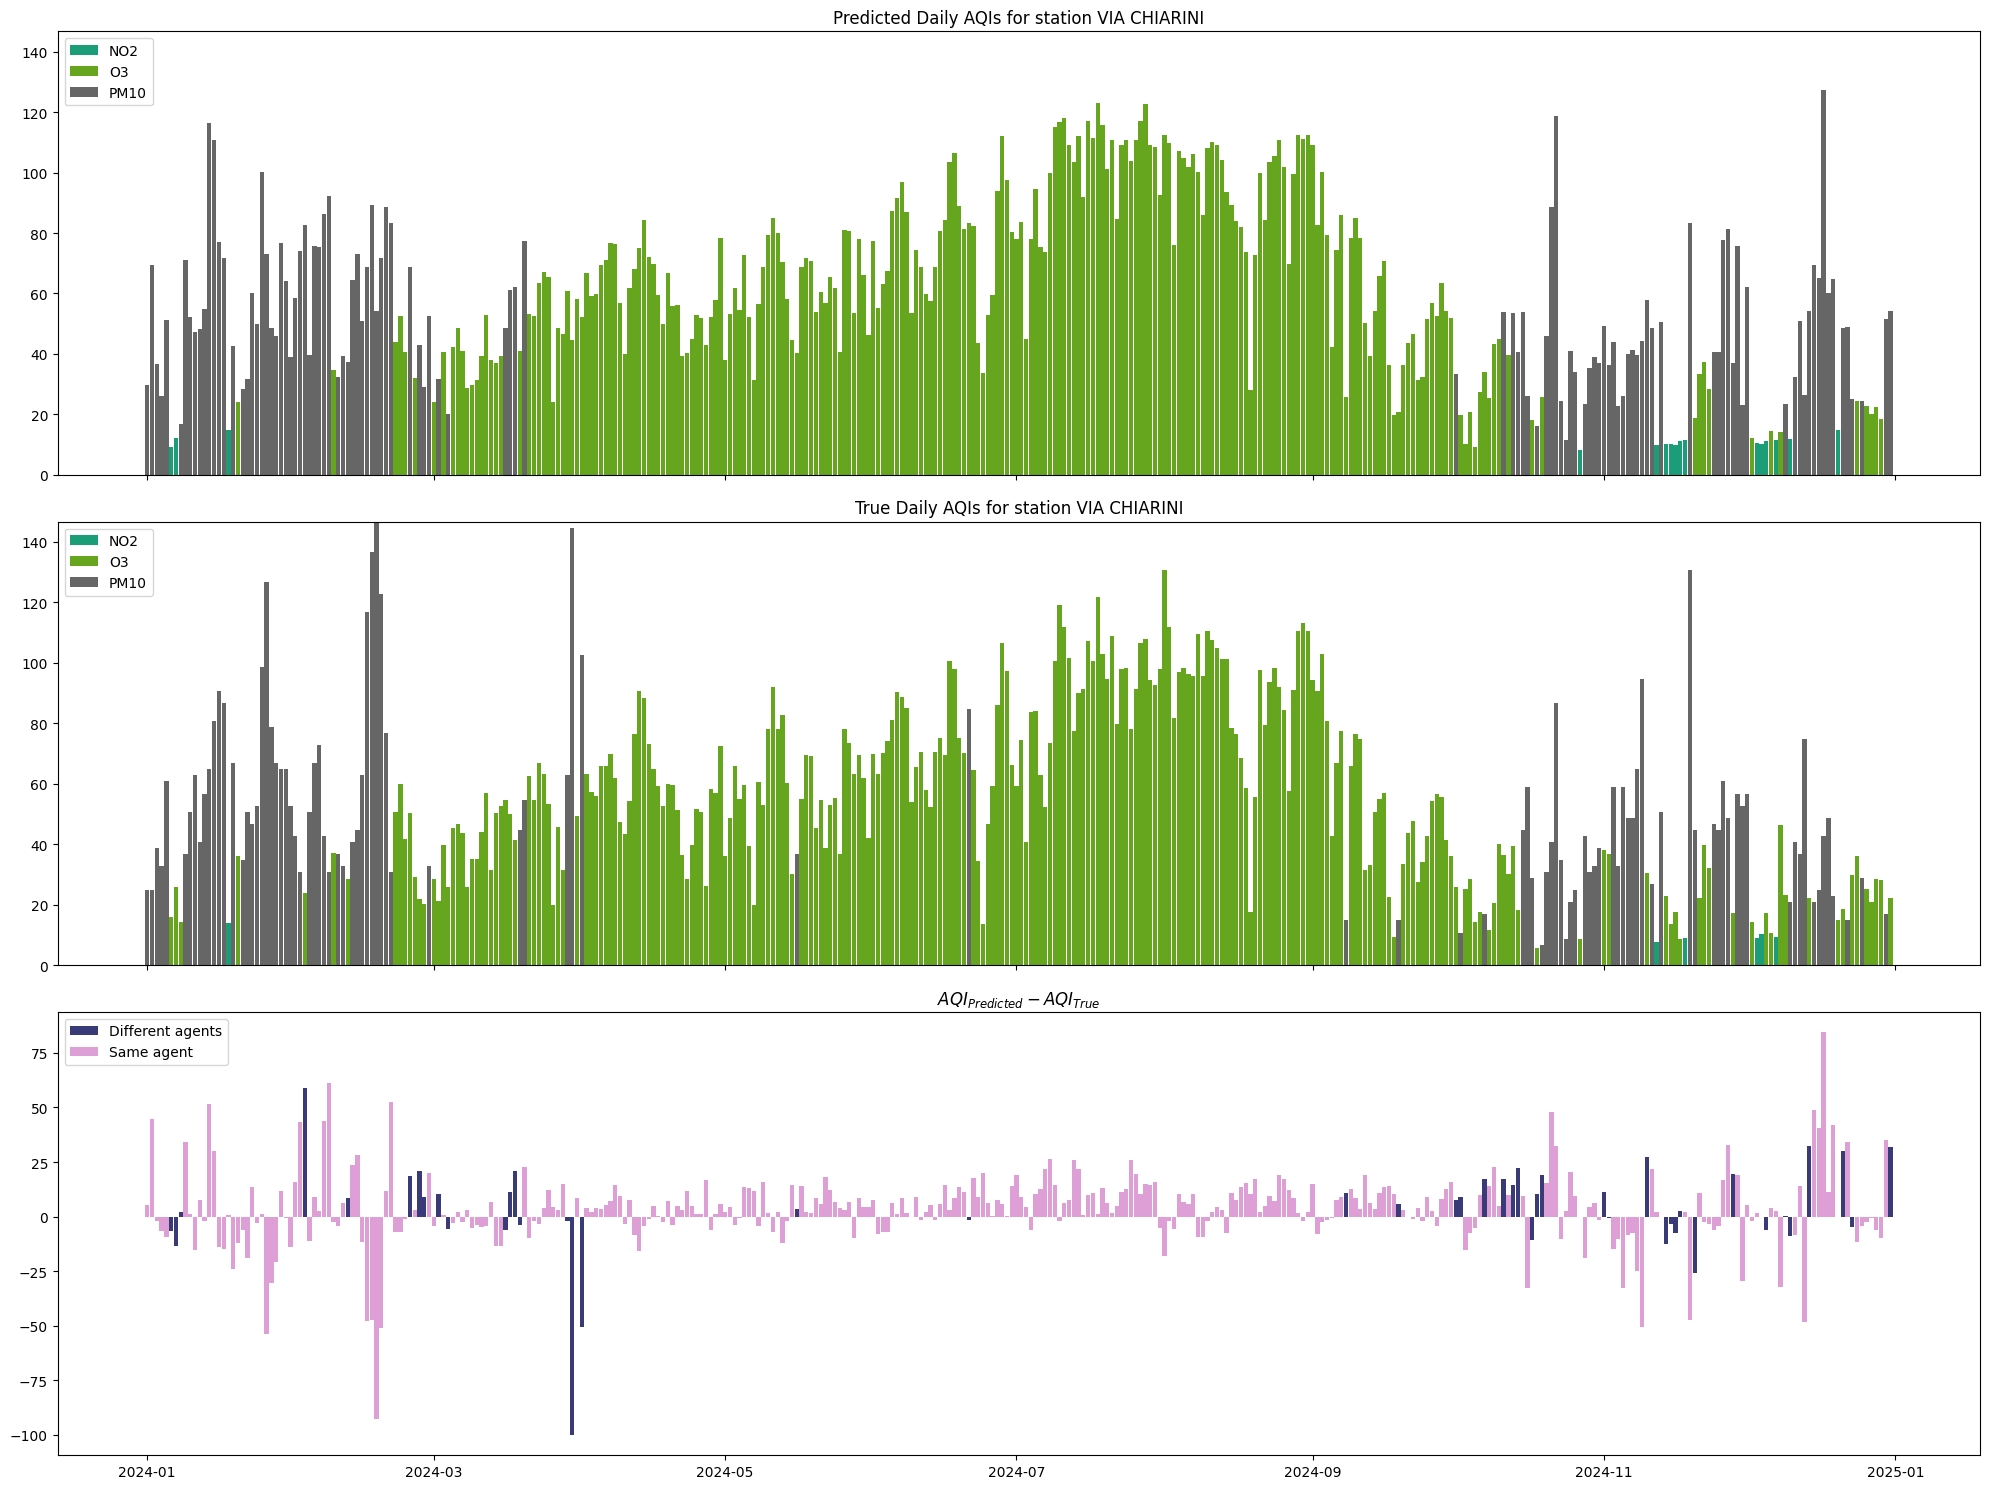

In [98]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_daily[station]['AQI'].max(),true_AQI_daily[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        figsize=(20, 5), s=start,e=end,ylims=ylims)

Station GIARDINI MARGHERITA Daily


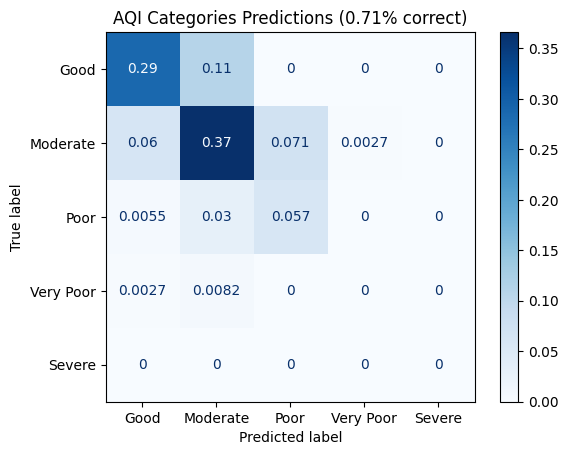

---------------------------------------------
> Absolute Mean AQI Difference: 13.28
> Positive Average AQI Difference: 11.73
> Negative Average AQI Difference: -15.28
> Percentage of Positive Differences: 56.28%
> Percentage of Negative Differences: 43.72%
> Percentage of Agent Values:
   - Same agent: 75.68
   - Different agents: 24.32
Station PORTA SAN FELICE Daily


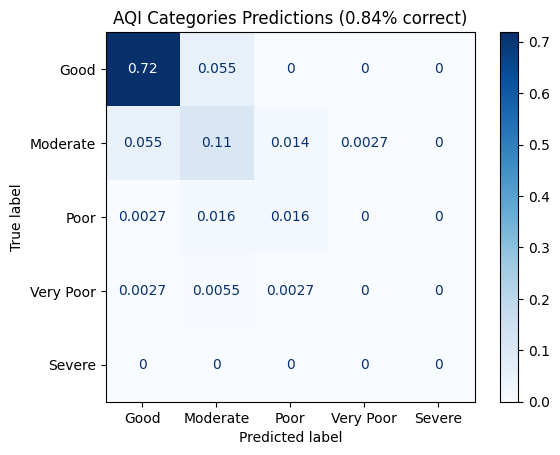

---------------------------------------------
> Absolute Mean AQI Difference: 13.90
> Positive Average AQI Difference: 12.34
> Negative Average AQI Difference: -16.36
> Percentage of Positive Differences: 61.20%
> Percentage of Negative Differences: 38.80%
> Percentage of Agent Values:
   - Same agent: 50.55
   - Different agents: 49.45
Station VIA CHIARINI Daily


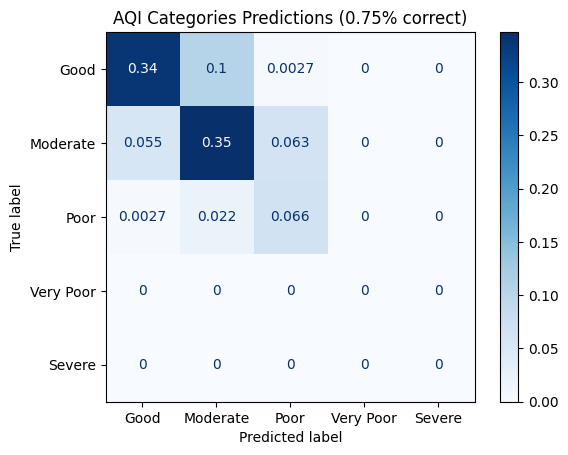

---------------------------------------------
> Absolute Mean AQI Difference: 12.15
> Positive Average AQI Difference: 12.40
> Negative Average AQI Difference: -11.71
> Percentage of Positive Differences: 64.21%
> Percentage of Negative Differences: 35.79%
> Percentage of Agent Values:
   - Same agent: 86.89
   - Different agents: 13.11


In [99]:
for station in pred_AQI_daily:
    print('=============================================')
    print(f'Station {station} Daily')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_daily[station], true_AQI_daily[station], categories=AQI_CATEGORIES)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')